In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_datetime64_any_dtype, is_numeric_dtype
from scipy.stats import ks_2samp, gaussian_kde, pearsonr, pointbiserialr, chi2_contingency

import catboost as cb 
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

In [2]:
class bcolors:
    """Coloring for print statements in terminal/logs"""
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKCYAN = "\033[96m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"

In [3]:
# Visualize the speed distribution
metrics_df = pd.read_csv("Speed_Test_Interview_Project_Metrics_Table_v2.csv")
metrics_df.head()

/var/folders/nh/m91qpv214t9b8xssz75rnw580000gn/T/ipykernel_25032/923163011.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metrics_df = pd.read_csv("Speed_Test_Interview_Project_Metrics_Table_v2.csv")


,router_speedtest_tcp_64_download_Mbps_avg,slot_timestamp,ut_ping_loss_rate,cell_id,home_pop_id,gateway_id,satellite_id,ut_snr,expected_min_snr,ut_latency,link_failure_detected,ut_sat_elevation_angle_mean,number_of_ku_beam_targets,number_of_users_on_ku_beam,number_of_users_on_ku_beam_target,ku_beam_target_cell_id,local_hour,country_code,test_id
0,278.145844,2021-12-21T15:26:12Z,0.000000,1050959,12,10158,1288,8.468927,5.640497,62.020656,False,0.446739,1,5,5,1050645,23,AU,1
1,174.016281,2021-12-21T15:06:42Z,0.117603,1051272,13,10053,1238,8.707482,5.358471,81.091325,False,0.543679,1,31,31,1051588,23,AU,2
2,249.541458,2021-12-21T15:05:57Z,0.038403,1050955,12,10158,2485,8.867315,6.762557,94.460829,False,0.446760,1,59,59,1050956,23,AU,3
3,222.936905,2021-12-21T14:08:42Z,0.000000,1050962,12,10053,1762,9.449574,6.403923,71.237235,False,0.486477,1,3,3,1050648,22,AU,4
4,106.995003,2021-12-21T13:58:27Z,0.000000,835617,13,10375,2474,7.331825,5.267703,36.324433,False,0.696587,2,71,49,835617,23,AU,5


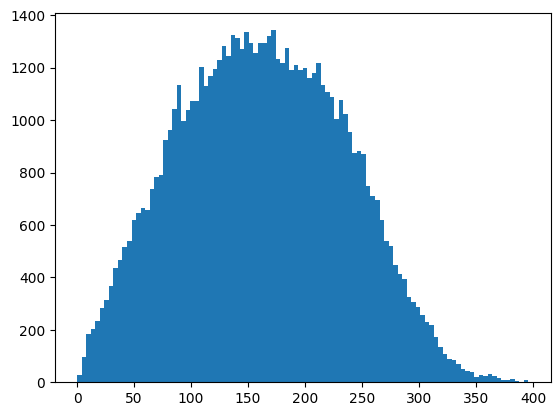

Number of unique slot_timestamps: 26663


In [4]:
plt.hist(metrics_df['router_speedtest_tcp_64_download_Mbps_avg'], bins=100)
plt.show()
print(f"Number of unique slot_timestamps: {metrics_df['slot_timestamp'].nunique()}")

In [5]:
print("Check NaNs...")
metrics_df.isna().sum().sort_values(ascending=False)

Check NaNs...


link_failure_detected                        44153
ut_ping_loss_rate                              164
router_speedtest_tcp_64_download_Mbps_avg        0
country_code                                     0
local_hour                                       0
ku_beam_target_cell_id                           0
number_of_users_on_ku_beam_target                0
number_of_users_on_ku_beam                       0
number_of_ku_beam_targets                        0
ut_sat_elevation_angle_mean                      0
ut_latency                                       0
slot_timestamp                                   0
expected_min_snr                                 0
ut_snr                                           0
satellite_id                                     0
gateway_id                                       0
home_pop_id                                      0
cell_id                                          0
test_id                                          0
dtype: int64

# EDA - Covariate Shift Analysis

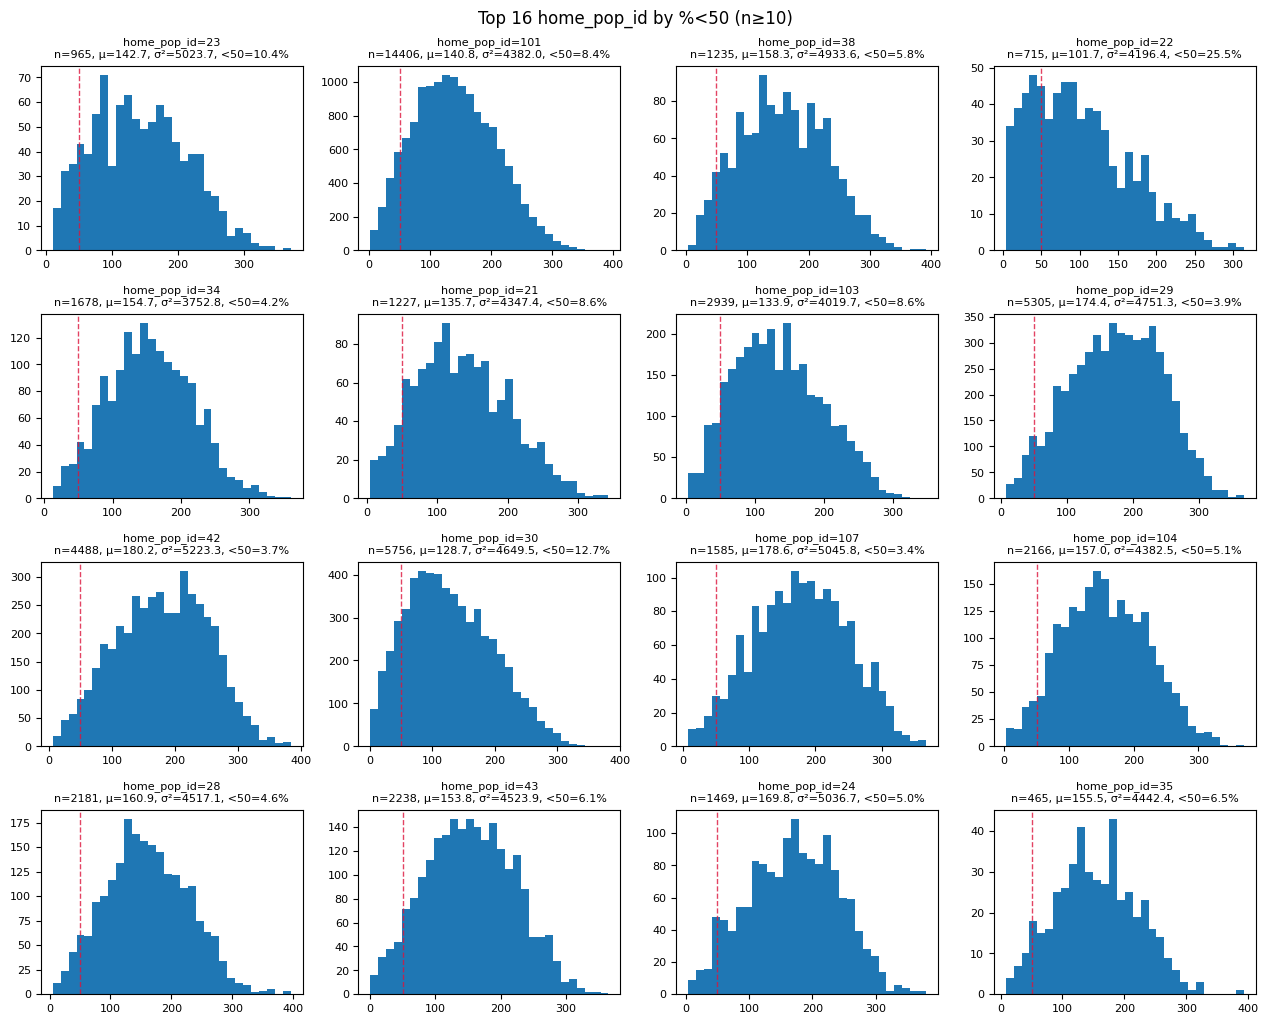

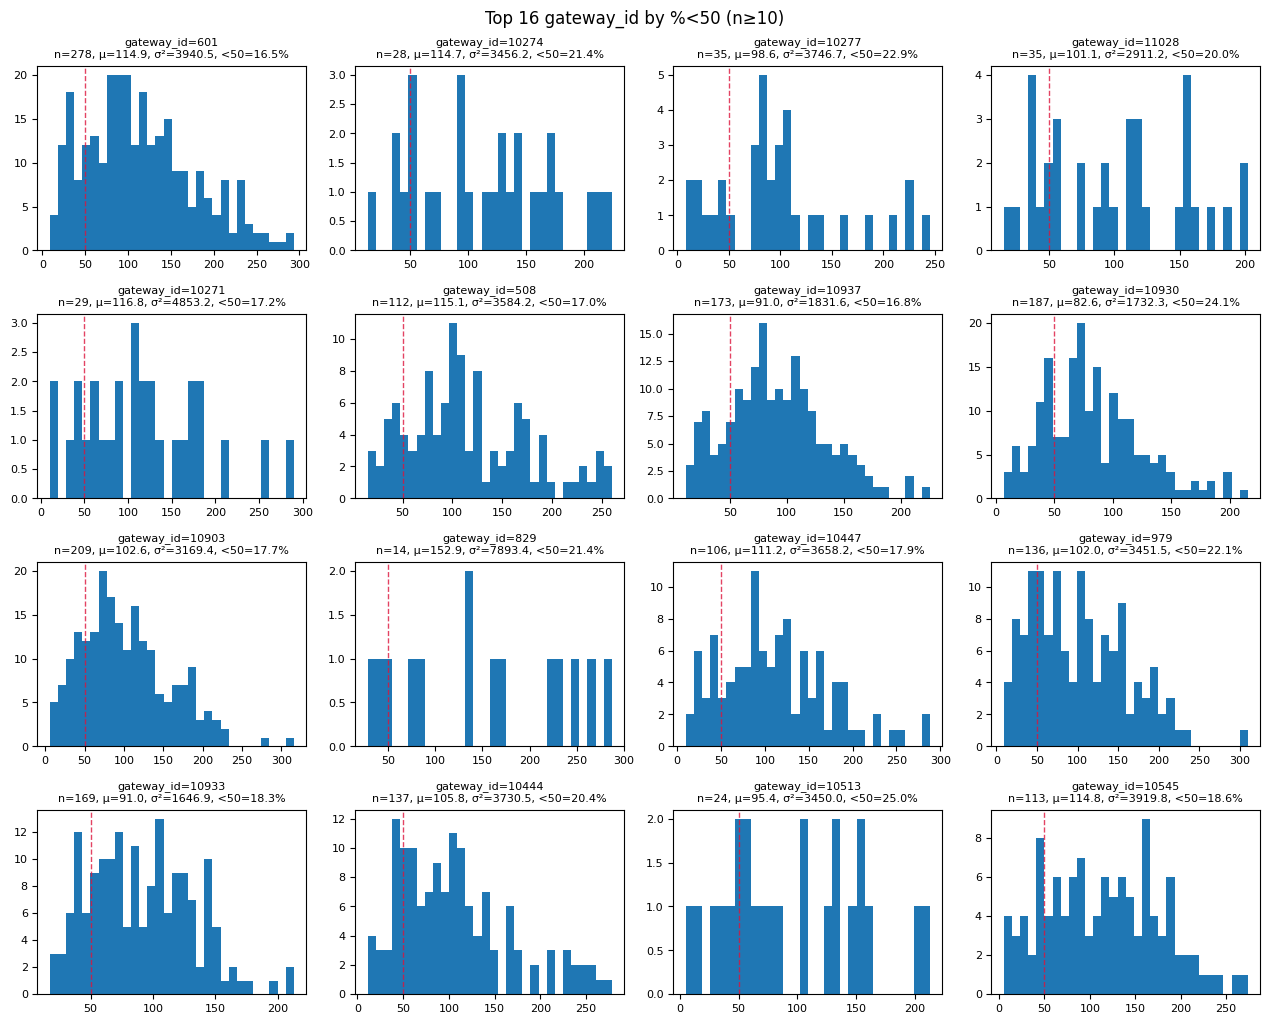

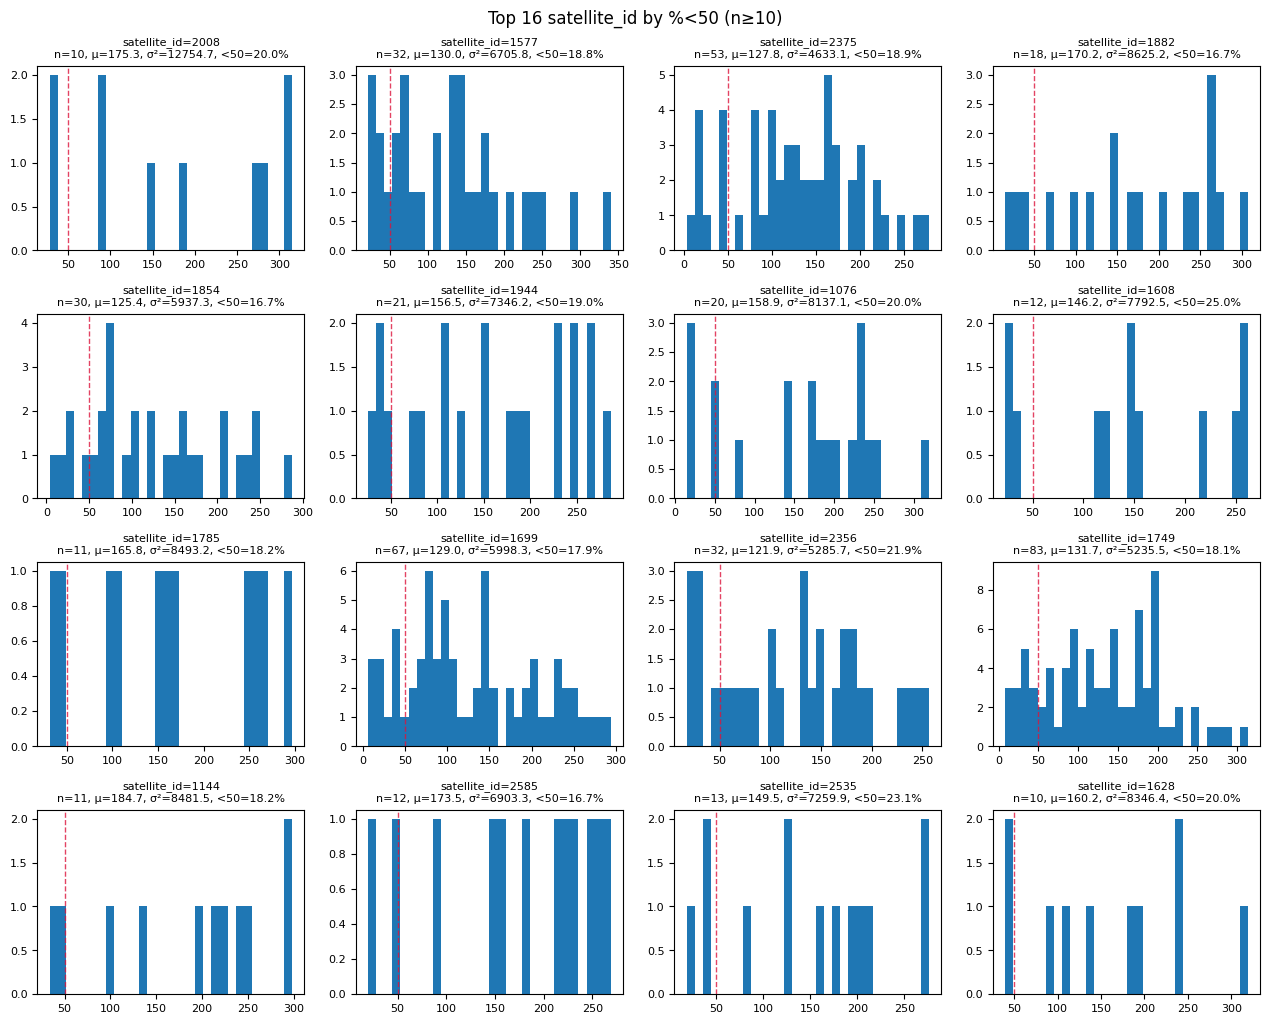

In [6]:
"""

    EDA on physical infrastructure of 
    the Starlink network

    Evaluating the actual PoPs, Gateways, and Satellites
    to see if any are associated with particularly slow speeds
    (potentially indicating congestion or other issues)

"""

scol = 'router_speedtest_tcp_64_download_Mbps_avg'
indices = ['home_pop_id', 'gateway_id', 'satellite_id']
top_k = 16
min_n = 10
bins = 30


def plot_slowest_hists_by_index(df, index_col, scol, top_k=8, min_n=10, bins=30, threshold=50):
    sub = df[[index_col, scol]].dropna()

    # Compute per-group stats, including share below threshold
    grp_counts_means = sub.groupby(index_col)[scol].agg(n='count', mu='mean')
    share_below = sub.assign(_lt=(sub[scol] < threshold)).groupby(index_col)['_lt'].mean().rename('p_lt')
    stats = grp_counts_means.join(share_below)

    # Select top groups by highest percent below threshold (edge-case slow). 
    # This metric is used because it normalizes the comparison between different groups (PoPs, Gateways, Satellites) against the quantity
    # of speed tests that run on each piece of infrastructure.
    eligible = stats[stats['n'] >= min_n]
    if eligible.empty:
        print(f'No groups in {index_col} with ≥ {min_n} samples.')
        return
    slow_ids = eligible.sort_values(['p_lt', 'mu'], ascending=[False, True]).head(top_k).index

    sub = sub[sub[index_col].isin(slow_ids)].copy()
    sub[index_col] = sub[index_col].astype(str)

    groups = [g for _, g in sub.groupby(index_col, sort=False)]
    n = len(groups)
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(3.2*cols, 2.6*rows))
    axs = np.atleast_1d(axs).ravel()

    for ax, g in zip(axs, groups):
        s = g[scol].values
        m = float(np.mean(s))
        v = float(np.var(s, ddof=1)) if len(s) > 1 else 0.0
        pct_lt = 100.0 * float((s < threshold).mean()) if len(s) > 0 else 0.0

        ax.hist(s, bins=bins, color='C0')
        ax.axvline(threshold, color='crimson', linestyle='--', linewidth=1, alpha=0.8)

        label = g[index_col].iloc[0]
        ax.set_title(f'{index_col}={label}\nn={len(s)}, μ={m:.1f}, σ²={v:.1f}, <{threshold}={pct_lt:.1f}%', fontsize=8)
        ax.tick_params(labelsize=8)

    for ax in axs[n:]:
        ax.axis('off')

    fig.suptitle(f'Top {top_k} {index_col} by %<{threshold} (n≥{min_n})', fontsize=12, y=0.98)
    plt.tight_layout()
    plt.show()

for idx in indices:
    plot_slowest_hists_by_index(metrics_df, idx, scol, top_k=top_k, min_n=min_n, bins=bins)

## Better idea:

look for covariate shift between records that are slow and nonslow records

In [7]:
slow_records = metrics_df[metrics_df['router_speedtest_tcp_64_download_Mbps_avg'] < 50]
nonslow_records = metrics_df[metrics_df['router_speedtest_tcp_64_download_Mbps_avg'] >= 50]

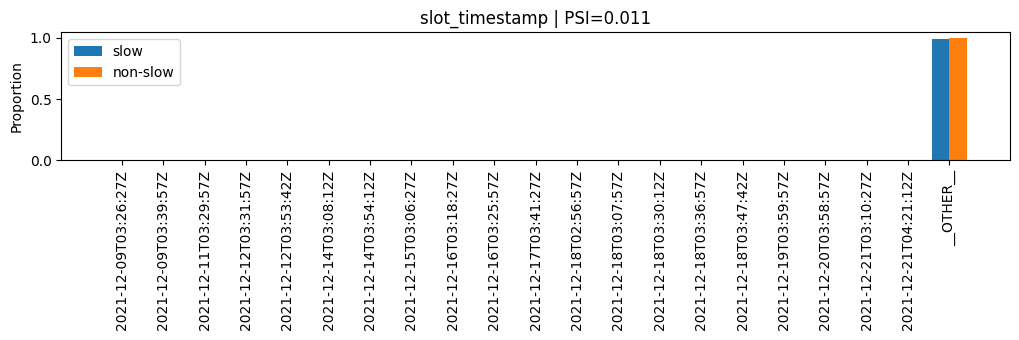

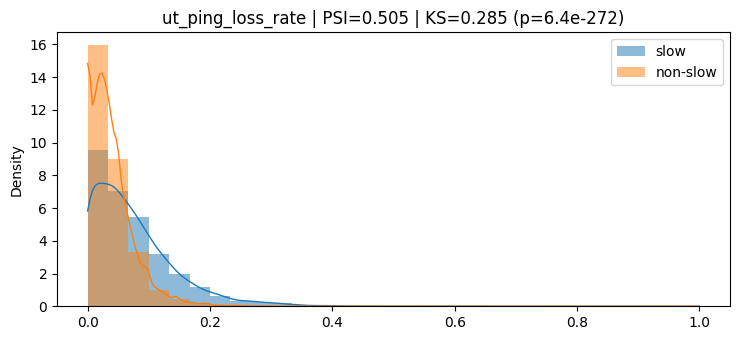

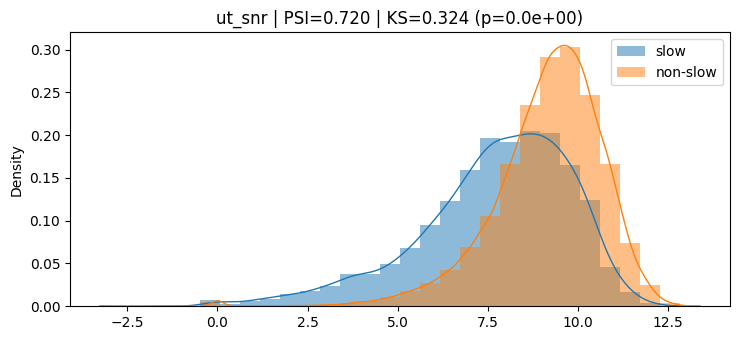

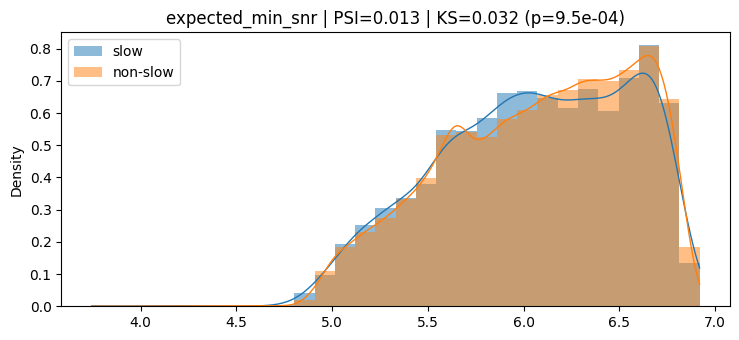

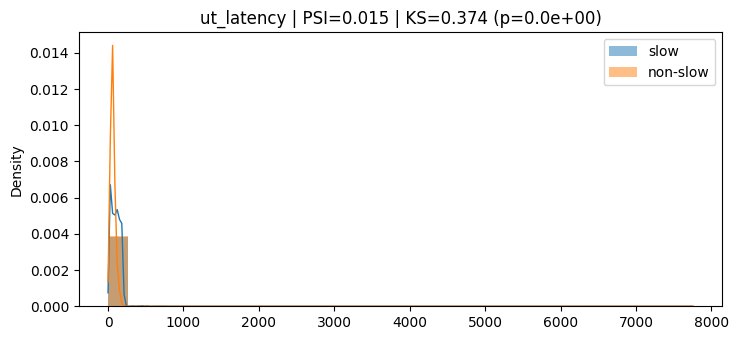

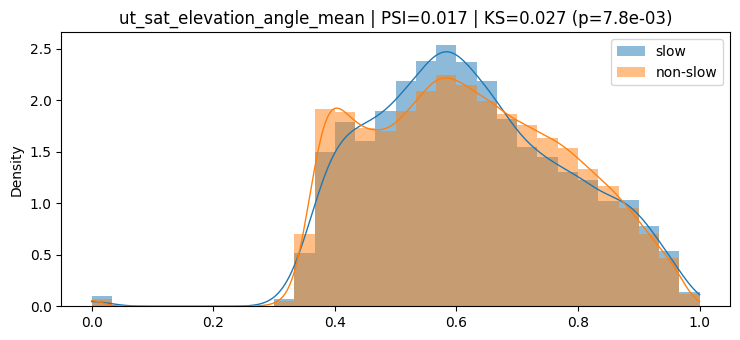

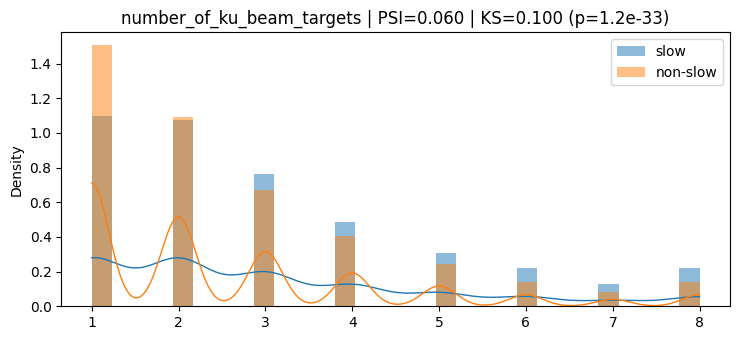

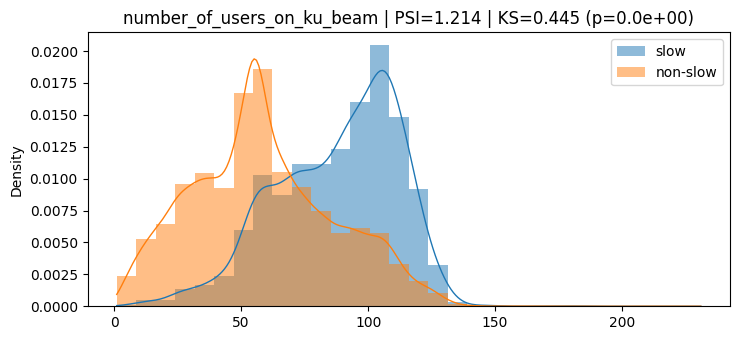

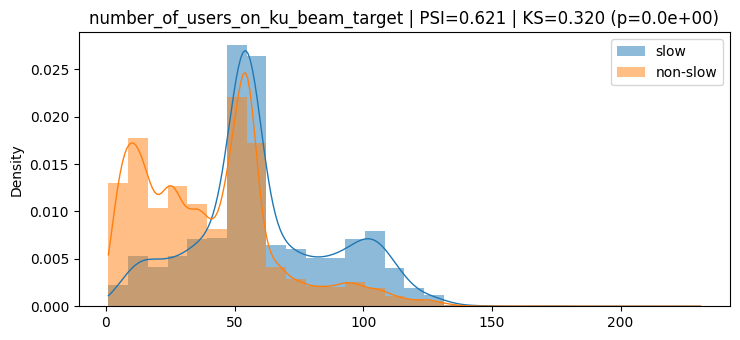

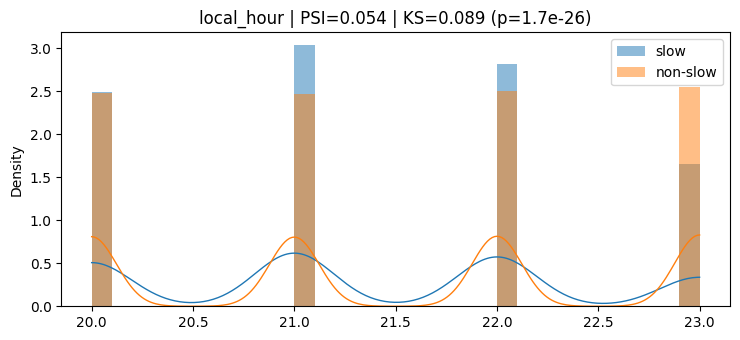

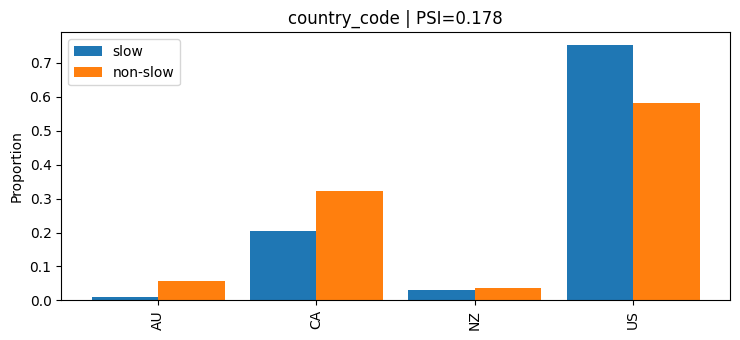

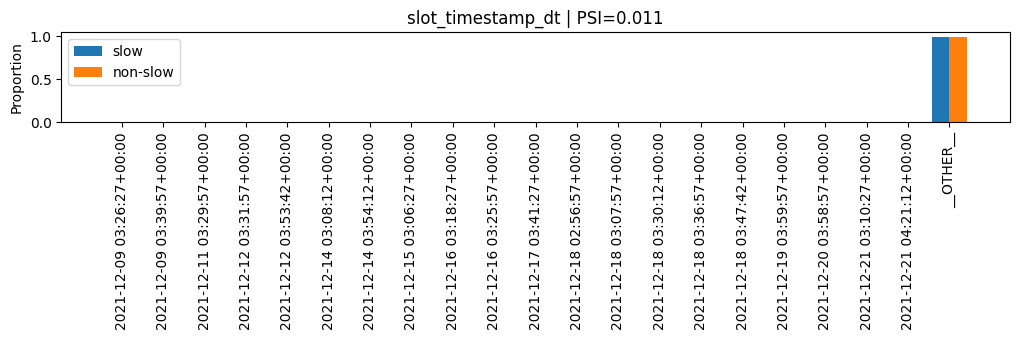

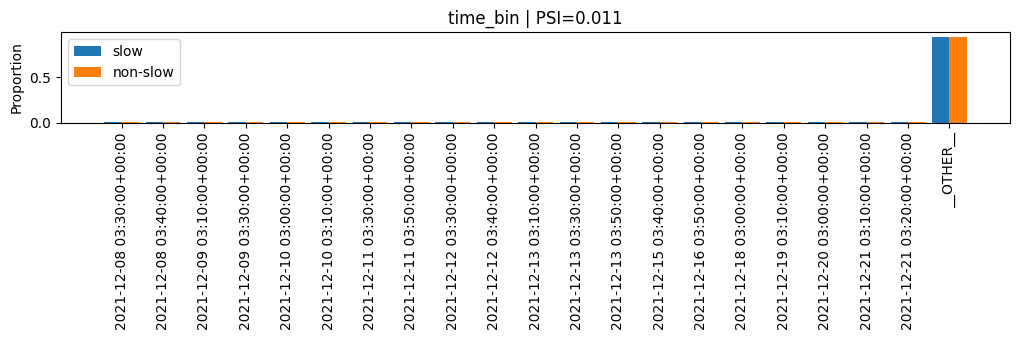

In [8]:

scol = 'router_speedtest_tcp_64_download_Mbps_avg'
features = [
    'slot_timestamp','ut_ping_loss_rate',
    # 'cell_id',
    # 'home_pop_id','gateway_id','satellite_id',
    'ut_snr','expected_min_snr','ut_latency',
    'ut_sat_elevation_angle_mean','number_of_ku_beam_targets','number_of_users_on_ku_beam',
    'number_of_users_on_ku_beam_target',
    # 'ku_beam_target_cell_id',
    'local_hour','country_code','slot_timestamp_dt',
    'time_bin'
]

# Ensure time features exist
if 'slot_timestamp_dt' not in metrics_df.columns:
    _dt = pd.to_datetime(metrics_df['slot_timestamp'], errors='coerce')
    metrics_df['slot_timestamp_dt'] = _dt
    metrics_df['time_bin'] = _dt.dt.floor('10min')

slow = metrics_df[metrics_df[scol] < 50].copy()
non  = metrics_df[metrics_df[scol] >= 50].copy()

eps = 1e-6

def psi_numeric(a, b, max_bins=30):
    s = pd.concat([a, b]).astype(float).dropna().values
    if s.size == 0 or np.unique(s).size < 2:
        return np.nan
    edges = np.histogram_bin_edges(s, bins=min(max_bins, max(5, np.unique(s).size)))
    ha, _ = np.histogram(pd.to_numeric(a, errors='coerce').dropna().values, bins=edges)
    hb, _ = np.histogram(pd.to_numeric(b, errors='coerce').dropna().values, bins=edges)
    pa = ha.astype(float); pb = hb.astype(float)
    pa = np.clip(pa / max(pa.sum(), eps), eps, 1)
    pb = np.clip(pb / max(pb.sum(), eps), eps, 1)
    return float(np.sum((pa - pb) * np.log(pa / pb)))

def psi_categorical(a, b, top=20):
    sa = a.astype('string'); sb = b.astype('string')
    vc = pd.concat([sa, sb]).value_counts()
    keep = set(vc.head(top).index)
    sa = sa.where(sa.isin(keep), '__OTHER__'); sb = sb.where(sb.isin(keep), '__OTHER__')
    cats = list(sorted(set(pd.concat([sa, sb]).dropna().unique())))
    pa = sa.value_counts(normalize=True).reindex(cats, fill_value=0).values
    pb = sb.value_counts(normalize=True).reindex(cats, fill_value=0).values
    pa = np.clip(pa, eps, 1); pb = np.clip(pb, eps, 1)
    pa /= pa.sum(); pb /= pb.sum()
    return float(np.sum((pa - pb) * np.log(pa / pb))), cats, pa, pb

for f in features:
    if f not in metrics_df.columns:
        continue
    a = slow[f].dropna()
    b = non[f].dropna()
    if a.empty or b.empty:
        print(f'{f}: skip (empty a/b)')
        continue

    if is_numeric_dtype(metrics_df[f]):
        av = pd.to_numeric(a, errors='coerce').dropna().values
        bv = pd.to_numeric(b, errors='coerce').dropna().values
        if av.size == 0 or bv.size == 0:
            print(f'{f}: skip (non-numeric after coercion)')
            continue

        psi = psi_numeric(a, b)
        if np.unique(av).size > 1 and np.unique(bv).size > 1:
            ks = ks_2samp(av, bv, alternative='two-sided', mode='auto')
            ks_stat, ks_p = float(ks.statistic), float(ks.pvalue)
        else:
            ks_stat, ks_p = np.nan, np.nan

        edges = np.histogram_bin_edges(np.concatenate([av, bv]), bins=30)
        fig, ax = plt.subplots(figsize=(7.5, 3.5))
        ax.hist(av, bins=edges, density=True, alpha=0.5, label='slow', edgecolor='none')
        ax.hist(bv, bins=edges, density=True, alpha=0.5, label='non-slow', edgecolor='none')

        # Optional KDE if sufficient variability
        try:
            if np.unique(av).size > 1:
                xs = np.linspace(edges[0], edges[-1], 256)
                ax.plot(xs, gaussian_kde(av)(xs), color='C0', linewidth=1)
            if np.unique(bv).size > 1:
                xs = np.linspace(edges[0], edges[-1], 256)
                ax.plot(xs, gaussian_kde(bv)(xs), color='C1', linewidth=1)
        except Exception:
            pass

        ax.set_title(f'{f} | PSI={psi:.3f} | KS={ks_stat if not np.isnan(ks_stat) else np.nan:.3f} (p={ks_p if not np.isnan(ks_p) else np.nan:.1e})')
        ax.legend()
        ax.set_ylabel('Density')
        plt.tight_layout()
        plt.show()

    else:
        psi, cats, pa, pb = psi_categorical(a, b, top=20)
        x = np.arange(len(cats))
        w = 0.42
        fig, ax = plt.subplots(figsize=(max(7.5, 0.3*len(cats)+4), 3.5))
        ax.bar(x - w/2, pa, width=w, label='slow')
        ax.bar(x + w/2, pb, width=w, label='non-slow')
        ax.set_xticks(x)
        ax.set_xticklabels(cats, rotation=90)
        ax.set_ylabel('Proportion')
        ax.set_title(f'{f} | PSI={psi:.3f}')
        ax.legend()
        plt.tight_layout()
        plt.show()

In [9]:
# Target (binary slow flag) and helper
target_bin = (metrics_df[scol] < 50).astype(int)

def cramers_v_corrected(x, y):
    tbl = pd.crosstab(x, y)
    if tbl.size == 0 or (tbl.values.sum() == 0):
        return np.nan, np.nan, 0
    chi2, p, dof, _ = chi2_contingency(tbl)
    n = tbl.values.sum()
    if n == 0:
        return np.nan, np.nan, dof
    phi2 = chi2 / n
    r, k = tbl.shape
    # Bias correction (Bergsma 2013)
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / max(n-1, 1))
    rcorr = r - ((r-1)**2) / max(n-1, 1)
    kcorr = k - ((k-1)**2) / max(n-1, 1)
    denom = max(min(kcorr-1, rcorr-1), 1e-12)
    V = np.sqrt(phi2corr / denom)
    return float(V), float(p), dof

# Split features by dtype present
present_feats = [f for f in features if f in metrics_df.columns]
num_feats = [f for f in present_feats if is_numeric_dtype(metrics_df[f])]
cat_feats = [f for f in present_feats if not is_numeric_dtype(metrics_df[f])]

# Numeric vs continuous speed + slow flag (point-biserial)
num_rows = []
for f in num_feats:
    x = pd.to_numeric(metrics_df[f], errors='coerce')
    y = pd.to_numeric(metrics_df[scol], errors='coerce')

    m = x.notna() & y.notna()
    if m.sum() >= 3 and np.unique(x[m]).size > 1 and np.unique(y[m]).size > 1:
        r, p = pearsonr(x[m], y[m])
    else:
        r, p = np.nan, np.nan

    # point-biserial with slow flag (equiv. Pearson with binary)
    m2 = x.notna() & target_bin.notna()
    if m2.sum() >= 3 and np.unique(x[m2]).size > 1 and np.unique(target_bin[m2]).size > 1:
        r_pb, p_pb = pointbiserialr(target_bin[m2], x[m2])
    else:
        r_pb, p_pb = np.nan, np.nan

    num_rows.append({
        'feature': f,
        'n_speed': int(m.sum()),
        'pearson_r_speed': float(r) if pd.notna(r) else np.nan,
        'r2_speed': float(r*r) if pd.notna(r) else np.nan,
        'p_speed': float(p) if pd.notna(p) else np.nan,
        'n_slow': int(m2.sum()),
        'point_biserial_r_slow': float(r_pb) if pd.notna(r_pb) else np.nan,
        'r2_slow': float(r_pb*r_pb) if pd.notna(r_pb) else np.nan,
        'p_slow': float(p_pb) if pd.notna(p_pb) else np.nan,
    })

corr_num = pd.DataFrame(num_rows).sort_values('r2_slow', ascending=False)
display(corr_num.head(25))

# Categorical vs slow flag (Cramér’s V)
cat_rows = []
for f in cat_feats:
    s = metrics_df[f].astype('string')
    tmp = pd.DataFrame({'cat': s, 'slow': target_bin})
    tmp = tmp.dropna()
    # optionally cap very high-cardinality to top categories
    if tmp['cat'].nunique() > 200:
        top = tmp['cat'].value_counts().head(200).index
        tmp['cat'] = tmp['cat'].where(tmp['cat'].isin(top), '__OTHER__')

    if tmp.shape[0] == 0 or tmp['cat'].nunique() < 2:
        V, p, dof = np.nan, np.nan, 0
    else:
        V, p, dof = cramers_v_corrected(tmp['cat'], tmp['slow'])

    cat_rows.append({
        'feature': f,
        'n': int(tmp.shape[0]),
        'n_levels': int(tmp['cat'].nunique()),
        'cramers_v_slow': V,
        'chi2_pval': p,
        'dof': dof,
    })

corr_cat = pd.DataFrame(cat_rows).sort_values('cramers_v_slow', ascending=False)
display(corr_cat.head(25))

# Optional: show top correlations neatly
print("Top numeric by R^2 vs slow flag:")
display(corr_num[['feature','r2_slow','point_biserial_r_slow','p_slow']].head(15))

print("Top categorical by Cramér's V vs slow flag:")
display(corr_cat[['feature','cramers_v_slow','chi2_pval','n_levels','n']].head(15))

,feature,n_speed,pearson_r_speed,r2_speed,p_speed,n_slow,point_biserial_r_slow,r2_slow,p_slow
6,number_of_users_on_ku_beam,68119,-0.471412,0.222230,0.000000e+00,68119,0.239909,5.755631e-02,0.000000e+00
1,ut_snr,68119,0.427582,0.182827,0.000000e+00,68119,-0.213129,4.542400e-02,0.000000e+00
0,ut_ping_loss_rate,67955,-0.242774,0.058939,0.000000e+00,67955,0.199135,3.965465e-02,0.000000e+00
7,number_of_users_on_ku_beam_target,68119,-0.269977,0.072888,0.000000e+00,68119,0.175904,3.094229e-02,0.000000e+00
3,ut_latency,68119,-0.241645,0.058392,0.000000e+00,68119,0.169587,2.875976e-02,0.000000e+00
5,number_of_ku_beam_targets,68119,-0.162611,0.026442,0.000000e+00,68119,0.055602,3.091582e-03,8.679177e-48
8,local_hour,68119,0.062980,0.003966,7.911153e-61,68119,-0.031001,9.610651e-04,5.823598e-16
2,expected_min_snr,68119,0.031773,0.001010,1.089578e-16,68119,-0.010753,1.156165e-04,5.009944e-03
4,ut_sat_elevation_angle_mean,68119,0.021691,0.000471,1.497291e-08,68119,0.000851,7.240420e-07,8.242521e-01


,feature,n,n_levels,cramers_v_slow,chi2_pval,dof
1,country_code,68119,4,0.085998,1.626114e-109,3
3,time_bin,68119,201,0.066308,1.366684e-27,200
0,slot_timestamp,68119,201,0.026777,1.071330e-02,200
2,slot_timestamp_dt,68119,201,0.026777,1.071330e-02,200


Top numeric by R^2 vs slow flag:


,feature,r2_slow,point_biserial_r_slow,p_slow
6,number_of_users_on_ku_beam,5.755631e-02,0.239909,0.000000e+00
1,ut_snr,4.542400e-02,-0.213129,0.000000e+00
0,ut_ping_loss_rate,3.965465e-02,0.199135,0.000000e+00
7,number_of_users_on_ku_beam_target,3.094229e-02,0.175904,0.000000e+00
3,ut_latency,2.875976e-02,0.169587,0.000000e+00
5,number_of_ku_beam_targets,3.091582e-03,0.055602,8.679177e-48
8,local_hour,9.610651e-04,-0.031001,5.823598e-16
2,expected_min_snr,1.156165e-04,-0.010753,5.009944e-03
4,ut_sat_elevation_angle_mean,7.240420e-07,0.000851,8.242521e-01


Top categorical by Cramér's V vs slow flag:


,feature,cramers_v_slow,chi2_pval,n_levels,n
1,country_code,0.085998,1.626114e-109,4,68119
3,time_bin,0.066308,1.366684e-27,201,68119
0,slot_timestamp,0.026777,1.071330e-02,201,68119
2,slot_timestamp_dt,0.026777,1.071330e-02,201,68119


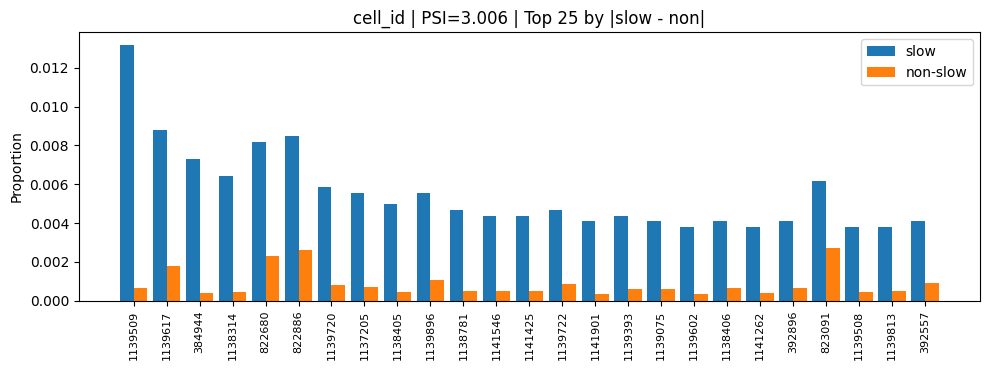

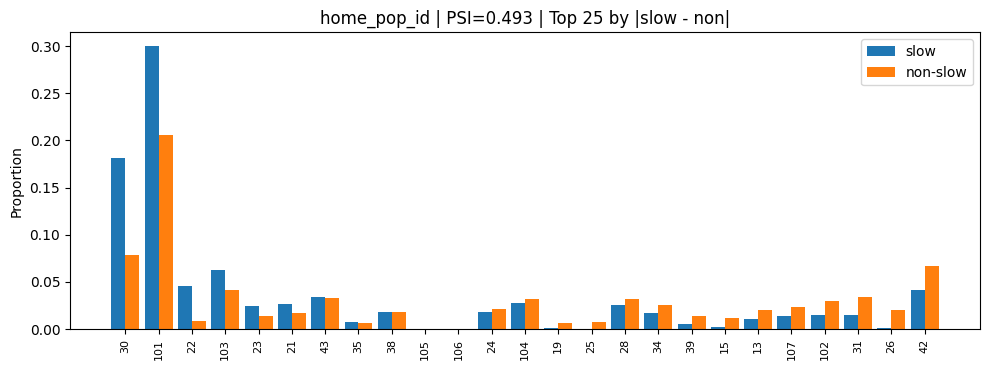

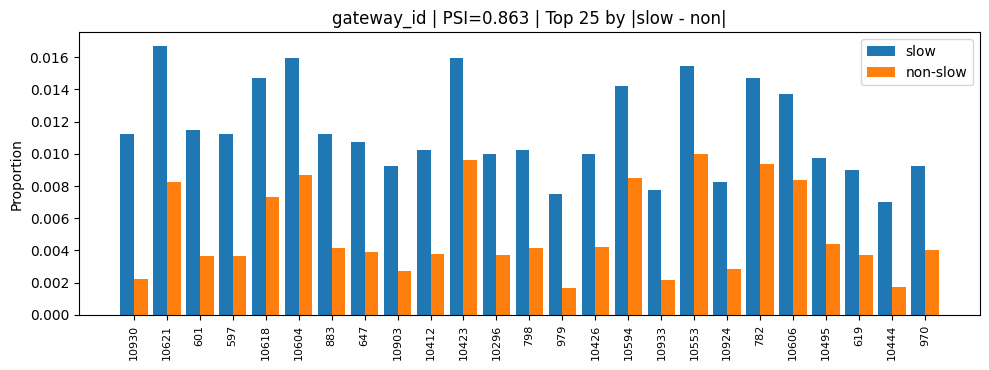

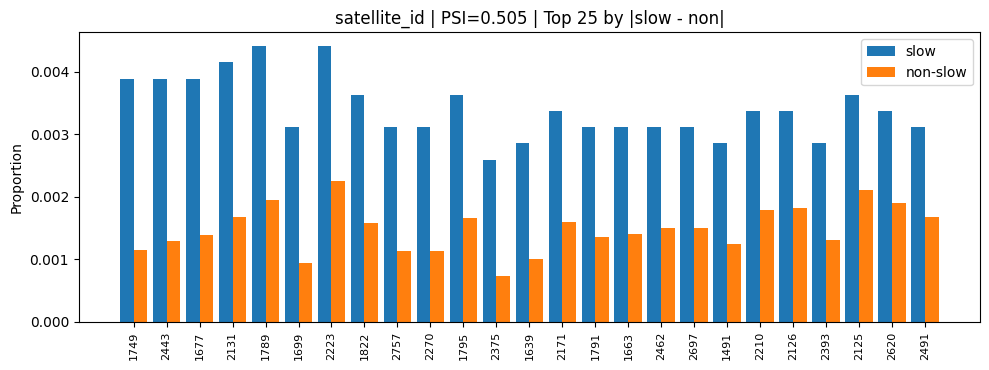

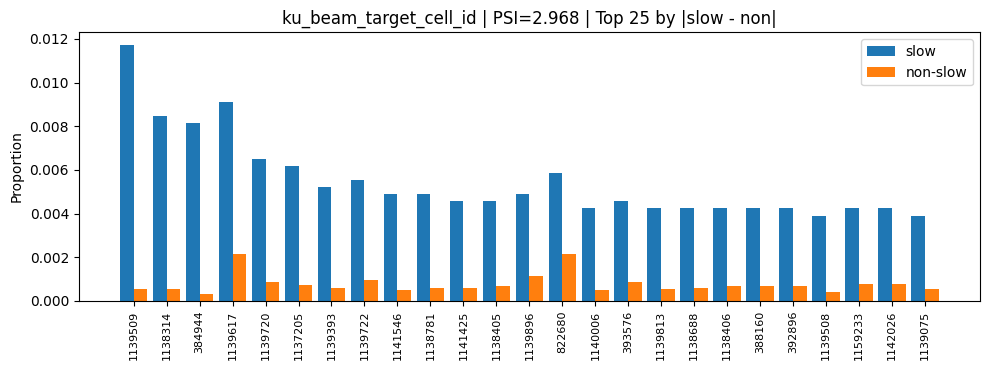

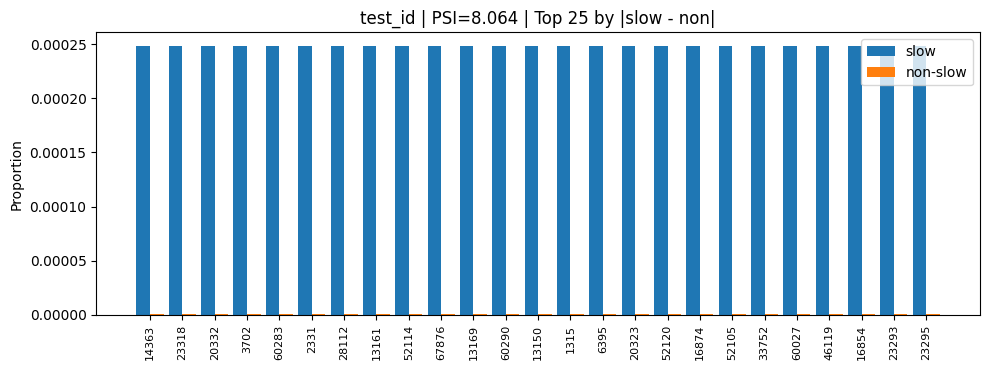

In [10]:
# Plot TOP-difference categories for *_id columns (slow vs non-slow)
id_cols = [c for c in metrics_df.columns if c.endswith('_id') or c in ['test_id']]
id_cols = [c for c in id_cols if c in metrics_df.columns]

top_k = 25          # how many categories to show per column
min_total = 20      # require at least this many combined samples across slow+non for a category

eps = 1e-6

for col in id_cols:
    sa = slow[col].astype('string').dropna()
    sb = non[col].astype('string').dropna()
    if sa.empty or sb.empty:
        print(f'{col}: skip (empty a/b)')
        continue

    cats = sorted(set(sa.unique()).union(set(sb.unique())))
    ca = sa.value_counts().reindex(cats, fill_value=0)
    cbb = sb.value_counts().reindex(cats, fill_value=0)
    total = ca + cbb

    # filter to avoid tiny, noisy categories
    mask = total >= min_total
    if mask.sum() == 0:
        mask = total >= 1  # fallback: keep all if everything is tiny

    cats_f = [c for c, m in zip(cats, mask.values) if m]
    ca = ca[mask]; cbb = cbb[mask]

    pa = ca.values.astype(float); pb = cbb.values.astype(float)
    pa = np.clip(pa / max(pa.sum(), eps), eps, 1)
    pb = np.clip(pb / max(pb.sum(), eps), eps, 1)

    # PSI over filtered cats
    psi = float(np.sum((pa - pb) * np.log(pa / pb)))

    # select by largest absolute difference
    diffs = pa - pb
    order = np.argsort(diffs)[::-1]
    if order.size > top_k:
        order = order[:top_k]

    cats_top = [cats_f[i] for i in order]
    pa_top = pa[order]; pb_top = pb[order]

    x = np.arange(len(cats_top))
    w = 0.42
    fig_w = max(7.5, 0.28*len(cats_top) + 3)
    fig, ax = plt.subplots(figsize=(fig_w, 3.8))
    ax.bar(x - w/2, pa_top, width=w, label='slow')
    ax.bar(x + w/2, pb_top, width=w, label='non-slow')

    ax.set_xticks(x)
    ax.set_xticklabels(cats_top, rotation=90, fontsize=8 if len(cats_top) <= 80 else 6)
    ax.set_ylabel('Proportion')
    ax.set_title(f'{col} | PSI={psi:.3f} | Top {len(cats_top)} by |slow - non|')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Predictive Model

In [11]:
# Perform a pd.merge to include gateway information
gateway_df = pd.read_csv("Speed_Test_Interview_Project_Gateways_Table.csv")
print(metrics_df.shape)
print(gateway_df.shape)

df = pd.merge(
    left = metrics_df,
    right = gateway_df,
    how = "left",
    on = ['slot_timestamp', "gateway_id", "satellite_id"],
    indicator = True
    )

df.head()

(68119, 21)
(70319, 9)


,router_speedtest_tcp_64_download_Mbps_avg,slot_timestamp,ut_ping_loss_rate,cell_id,home_pop_id,gateway_id,satellite_id,ut_snr,expected_min_snr,ut_latency,...,test_id,slot_timestamp_dt,time_bin,gateway_site_id,online_user_count,ka_beam_avg_util_percent,ka_beam_max_util_percent,ka_beam_active_count,local_hour_y,_merge
0,278.145844,2021-12-21T15:26:12Z,0.000000,1050959,12,10158,1288,8.468927,5.640497,62.020656,...,1,2021-12-21 15:26:12+00:00,2021-12-21 15:20:00+00:00,3019.0,43.0,3.0,20.0,8.0,23.0,both
1,174.016281,2021-12-21T15:06:42Z,0.117603,1051272,13,10053,1238,8.707482,5.358471,81.091325,...,2,2021-12-21 15:06:42+00:00,2021-12-21 15:00:00+00:00,61.0,100.0,2.0,17.0,8.0,23.0,both
2,249.541458,2021-12-21T15:05:57Z,0.038403,1050955,12,10158,2485,8.867315,6.762557,94.460829,...,3,2021-12-21 15:05:57+00:00,2021-12-21 15:00:00+00:00,3019.0,54.0,4.0,18.0,8.0,23.0,both
3,222.936905,2021-12-21T14:08:42Z,0.000000,1050962,12,10053,1762,9.449574,6.403923,71.237235,...,4,2021-12-21 14:08:42+00:00,2021-12-21 14:00:00+00:00,61.0,52.0,3.0,20.0,8.0,22.0,both
4,106.995003,2021-12-21T13:58:27Z,0.000000,835617,13,10375,2474,7.331825,5.267703,36.324433,...,5,2021-12-21 13:58:27+00:00,2021-12-21 13:50:00+00:00,57.0,919.0,11.0,22.0,8.0,23.0,both


### Handle `local_hour`

In [12]:
# Remove local_hour_x and local_hour_y and replace with local_hour_x. This is because we have UTC timestamps as well as a specific gateway ID 
# associated with the metrics table. We take local_hour_x as the source of truth for local hour.

df = df.drop(columns=['local_hour_y'], errors='ignore') 
df = df.rename(columns={'local_hour_x': 'local_hour'})

### Handle NaNs that appear in base tables and induced by `pd.merge`

In [13]:
df['_merge'].value_counts()

_merge
both          68358
left_only      4903
right_only        0
Name: count, dtype: int64

In [14]:
df.isna().sum().sort_values(ascending=False)

link_failure_detected                        47363
ka_beam_active_count                          4922
ka_beam_max_util_percent                      4921
ka_beam_avg_util_percent                      4921
online_user_count                             4903
gateway_site_id                               4903
ut_ping_loss_rate                              188
router_speedtest_tcp_64_download_Mbps_avg        0
ku_beam_target_cell_id                           0
time_bin                                         0
slot_timestamp_dt                                0
test_id                                          0
country_code                                     0
local_hour                                       0
number_of_users_on_ku_beam                       0
number_of_users_on_ku_beam_target                0
slot_timestamp                                   0
number_of_ku_beam_targets                        0
ut_sat_elevation_angle_mean                      0
ut_latency                     

### Create features & train/test split 

In [15]:
# # remove all _id columns
# id_cols = [c for c in df.columns if c.endswith('_id') or c in ['test_id']]
# df = df.drop(columns=id_cols, errors='ignore')


In [16]:
# Obtain all possible features
test_input_df = pd.read_csv("test_input.csv")

# Merge with gateway information
test_input_df = pd.merge(
    left = test_input_df,
    right = gateway_df,
    on = ['slot_timestamp', "gateway_id", "satellite_id"],
    how = "left",
    # indicator = True
)

# Address local hour
test_input_df = test_input_df.drop(columns=['local_hour_y'], errors='ignore')
test_input_df = test_input_df.rename(columns={'local_hour_x': 'local_hour'})


test_input_df.head()

,slot_timestamp,ut_ping_loss_rate,cell_id,home_pop_id,gateway_id,satellite_id,ut_snr,expected_min_snr,ut_latency,link_failure_detected,...,ku_beam_target_cell_id,local_hour,country_code,test_id,slow_speed,gateway_site_id,online_user_count,ka_beam_avg_util_percent,ka_beam_max_util_percent,ka_beam_active_count
0,2021-12-21T03:31:42Z,0.000000,1139718,101,10620,2685,8.820867,5.676411,31.474800,False,...,1139718,20,US,70001,NaN,20,1926,39.0,53.0,8.0
1,2021-12-21T03:31:27Z,0.003174,379485,104,10443,1867,9.535334,6.469141,29.762629,False,...,379485,23,US,70002,NaN,18,1212,44.0,64.0,4.0
2,2021-12-21T03:29:42Z,0.006506,391086,101,10536,1193,10.350437,5.745061,41.082993,False,...,391086,21,CA,70003,NaN,519,759,21.0,35.0,8.0
3,2021-12-21T15:33:57Z,0.114278,1051591,12,10034,1955,7.327727,5.593584,79.452012,False,...,1051591,23,AU,70004,NaN,61,110,2.0,14.0,8.0
4,2021-12-21T13:56:27Z,0.006506,841042,12,690,1393,10.529851,5.913839,43.851609,False,...,841043,23,AU,70005,NaN,53,720,9.0,20.0,8.0


In [17]:
# Perform intersection on features from "Speed_Test_Interview_Project_Metrics_Table_v2.csv" analysis above
possible_features = list(set(df.columns.tolist()).intersection(set(test_input_df.columns.tolist())))

# remove test_id
try:
    possible_features.remove('test_id')
except ValueError:
    pass
print(possible_features)

['ut_latency', 'satellite_id', 'number_of_ku_beam_targets', 'slot_timestamp', 'gateway_site_id', 'ku_beam_target_cell_id', 'ut_snr', 'ut_ping_loss_rate', 'link_failure_detected', 'home_pop_id', 'number_of_users_on_ku_beam', 'country_code', 'ka_beam_avg_util_percent', 'ut_sat_elevation_angle_mean', 'local_hour', 'cell_id', 'ka_beam_max_util_percent', 'expected_min_snr', 'ka_beam_active_count', 'online_user_count', 'gateway_id', 'number_of_users_on_ku_beam_target']


In [18]:
# Perform feature engineering to produce the binary target variable. TODO: Also test out a regression model predicting actual speed -> then produce binary from that.

df['slow_speed'] = df['router_speedtest_tcp_64_download_Mbps_avg'] < 50

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

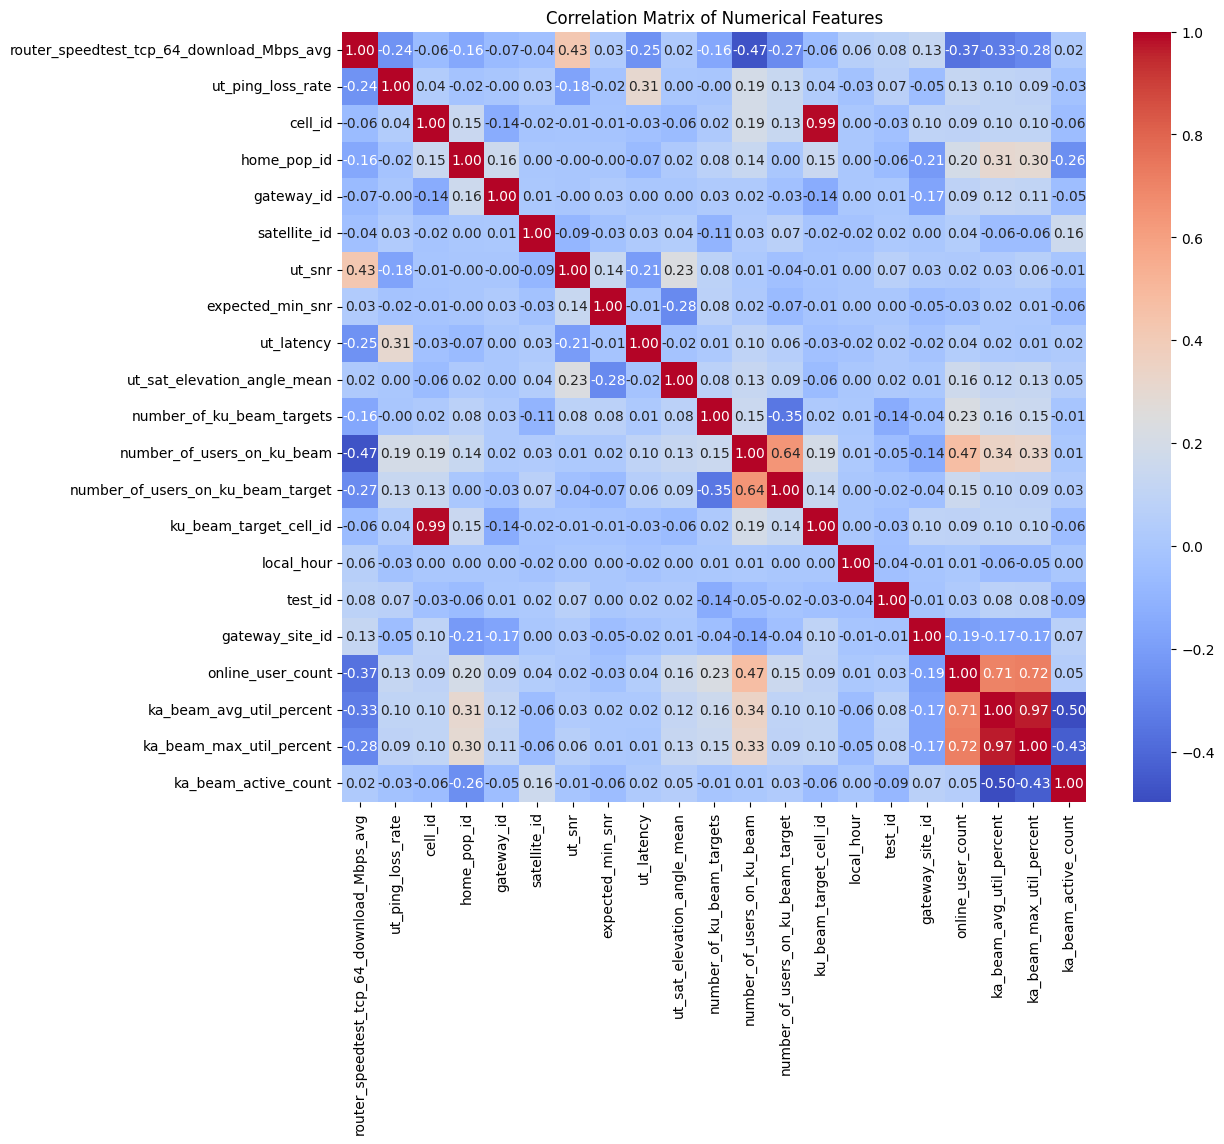

In [19]:
# Look a corr matrix of numerical features
num_df = df.select_dtypes(include=[np.number]).copy()
corr_matrix = num_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features')


In [20]:
def dtype_prep(df : pd.DataFrame , target_col=None, possible_features=None):
    """
    Prepares a DataFrame for XGBoost: handles timestamps, booleans, numerics, categoricals.
    If target_col is provided, returns (X, Y). Otherwise, returns X only.
    If possible_features is provided, only those columns are used.
    """

    # Use only possible_features if provided
    if possible_features is not None:
        X = df[possible_features].copy()
    else:
        X = df.copy()

    # 1) Timestamps -> numeric features, drop raw string column
    if 'slot_timestamp' in X.columns:
        X['slot_timestamp'] = pd.to_datetime(X['slot_timestamp'], errors='coerce', utc=True)
        X['slot_ts_unix'] = (X['slot_timestamp'].astype('int64') // 10**9).where(X['slot_timestamp'].notna(), np.nan)
        X['slot_hour_utc'] = X['slot_timestamp'].dt.hour
        X['slot_dow'] = X['slot_timestamp'].dt.dayofweek
        X = X.drop(columns=['slot_timestamp'])

    # 2) Coerce boolean-like strings -> bool
    def to_bool_series(s):
        mapping = {'true': True, 'false': False, '1': True, '0': False, 'yes': True, 'no': False}
        low = s.astype(str).str.lower()
        mapped = low.map(mapping)
        if mapped.notna().mean() > 0.95:
            return mapped.fillna(False).astype(bool)
        return None

    for c in list(X.columns):
        if X[c].dtype == 'object':
            b = to_bool_series(X[c])
            if b is not None:
                X[c] = b

    # 3) Numeric coercion (safe)
    for c in list(X.columns):
        if is_numeric_dtype(X[c]):
            X[c] = pd.to_numeric(X[c], errors='coerce')

    # 4) Mark categoricals explicitly
    cat_cols = [c for c in X.columns if c.endswith('_id') or c in ['test_id','cell_id','ku_beam_target_cell_id','country_code']]
    for c in cat_cols:
        if c in X.columns:
            X[c] = X[c].astype('category')

    # 5) Any remaining objects -> category (fallback through string)
    for c in X.columns[X.dtypes == 'object']:
        X[c] = X[c].astype('string').astype('category')


    # 6) Add missingness flags for few high-impact columns
    for c in ["ut_snr","ut_latency","expected_min_snr","number_of_users_on_ku_beam"]:
        if c in df.columns:
            df[f"{c}__isna"] = df[c].isna().astype(int)


    # Final guard: fail early if any object remains
    bad = [c for c, dt in X.dtypes.items() if dt.name == 'object']
    if bad:
        print(f"⚠️ Fixing remaining object dtypes: {bad}")
        for c in bad:
            X[c] = X[c].astype('category')
    bad = [c for c, dt in X.dtypes.items() if dt.name == 'object']
    assert len(bad) == 0, f"Object dtypes still remain: {bad}"

    if target_col is not None and target_col in df.columns:
        Y = df[target_col].astype(bool)
        return X, Y
    else:
        return X


In [21]:
X, Y = dtype_prep(df, target_col='slow_speed', possible_features=possible_features)



# Split BEFORE final validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Final guard: fail early if any object remains in train set
bad = [c for c, dt in X_train.dtypes.items() if dt.name == 'object']
if bad:
    print(f"⚠️ Fixing remaining object dtypes in train: {bad}")
    for c in bad:
        X_train[c] = X_train[c].astype('category')
        X_test[c] = X_test[c].astype('category')

bad = [c for c, dt in X_train.dtypes.items() if dt.name == 'object']
assert len(bad) == 0, f"Object dtypes still remain: {bad}"

In [22]:
# ============================================================
#  CatBoost — minority-first, simple, and strong (CLEAN BLOCK)
#  - Converts pandas categoricals -> CatBoost-safe string columns
#  - Class balancing via auto_class_weights
#  - Early stopping on PR-AUC
#  - Reports AP (PR-AUC), ROC-AUC + Top-K and threshold sweep
# ============================================================

# --- identify categorical columns from your prepared X_train ---
cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) == 'category']

# --- sanitizer: cast categorical columns to *string* with a missing sentinel ---
def to_cb_strings(df, cat_columns):
    X = df.copy()
    for c in cat_columns:
        X[c] = X[c].astype('string').fillna('__MISSING__').astype(str)
    return X

X_train_cb = to_cb_strings(X_train, cat_cols)
X_test_cb  = to_cb_strings(X_test,  cat_cols)

# cat_features can be column names OR integer indices; names are safer
cat_features = cat_cols  # pass names to CatBoost Pool

# --- build Pools once ---
train_pool = cb.Pool(X_train_cb, label=y_train.astype(int), cat_features=cat_features)
valid_pool = cb.Pool(X_test_cb,  label=y_test.astype(int),  cat_features=cat_features)

# # --- train CatBoost with PR-AUC focus and early stopping ---
# model_cb = cb.CatBoostClassifier(
#     loss_function='Logloss',
#     eval_metric='PRAUC',            # NOTE: optimize PR-AUC because of the heavy class imbalance!!!!
#     iterations=8000,
#     learning_rate=0.03,
#     depth=6,
#     l2_leaf_reg=8.0,
#     auto_class_weights='Balanced',  # class imbalance handling
#     random_seed=42,
#     od_type='Iter',                 # early stopping
#     od_wait=300,
#     verbose=200,
# )

# model_cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)


# --- stronger minority emphasis via explicit class_weights ---
pos = int(y_train.sum()); neg = int((y_train==0).sum())
w_pos = (neg / max(pos,1)) * 2.35   # >1 pushes recall harder; tune 1.2–2.0
w_neg = 1.0


# hand tuned hyperparams due to compute constraints... ideally this would be a hyperparam grid search
model_cb = cb.CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='PRAUC',
    custom_metric=['PRAUC','Recall','F1','AUC'],
    iterations=12000,
    learning_rate=0.05,           # faster learning (more aggressive)
    depth=8,                      # deeper trees capture rarer patterns
    l2_leaf_reg=3.0,              # lower L2 = less regularization (more fit)
    class_weights=[w_neg, w_pos], # stronger than auto_class_weights
    subsample=0.7,                # stochasticity helps PR curve
    rsm=0.7,                      # feature subsample per tree
    bagging_temperature=1.5,      # Bayesian bootstrap (more diversity)
    grow_policy='Lossguide',      # allow many narrow, high-gain leaves
    max_leaves=64,                # cap leaf explosion
    min_data_in_leaf=10,
    leaf_estimation_method='Newton',
    leaf_estimation_iterations=15,
    random_seed=42,
    od_type='Iter',
    od_wait=200,
    verbose=200,
)
model_cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)




# --- evaluate ranking quality ---
proba_cb = model_cb.predict_proba(valid_pool)[:, 1]
ap_cb    = average_precision_score(y_test, proba_cb)
roc_cb   = roc_auc_score(y_test, proba_cb)
print(f"[CatBoost] AP={ap_cb:.4f}  ROC-AUC={roc_cb:.4f}")

# --- fixed probability thresholds you requested (0.6, 0.7, 0.8) ---
for t in (0.6, 0.7, 0.8):
    yhat = (proba_cb >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = (2 * prec * rec) / max(prec + rec, 1e-12)
    print(f"thr={t:.1f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f} (TP={tp} FP={fp} TN={tn} FN={fn})")

# --- compact sweep: thresholds 0.1 → 0.9 (step 0.1) ---
thr_vals = np.round(np.linspace(0.1, 0.9, 9), 2)
rows = []
for t in thr_vals:
    yhat = (proba_cb >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = (2 * prec * rec) / max(prec + rec, 1e-12)
    rows.append((t, prec, rec, f1, tp, fp, tn, fn))
thr_table = pd.DataFrame(rows, columns=['threshold','precision','recall','f1','TP','FP','TN','FN'])
display(thr_table)

# --- Top-K labeling by validation prevalence (recall-centric) ---
multiplier = 1.0
K = int(max(1, round(y_test.sum() * multiplier)))
order = np.argsort(-proba_cb)
pred_topk = np.zeros_like(proba_cb, dtype=int); pred_topk[order[:K]] = 1
cm_topk  = confusion_matrix(y_test, pred_topk)
rep_topk = classification_report(y_test, pred_topk, target_names=['Non-Slow','Slow'])
print(f"\nTop-K labeling (K={K}, multiplier={multiplier}):")
print("Confusion matrix:\n", cm_topk)
print("\nClassification report:\n", rep_topk)

# (Optional) equivalent probability threshold for Top-K (for reference)
thr_equiv = float(np.partition(proba_cb, -K)[-K]) if K < len(proba_cb) else proba_cb.min() - 1e-9
print(f"(Optional) Equivalent probability threshold for Top-K ≈ {thr_equiv:.4f}")

# --- expose for downstream use ---
catboost_model   = model_cb
catboost_proba   = proba_cb
catboost_thr_top = thr_equiv
catboost_cat_cols = cat_cols  # keep the list for prod preprocessing


0:	learn: 0.9105022	test: 0.9053273	best: 0.9053273 (0)	total: 94ms	remaining: 18m 48s
200:	learn: 0.9709933	test: 0.9609205	best: 0.9609207 (199)	total: 7.84s	remaining: 7m 40s
400:	learn: 0.9900921	test: 0.9633599	best: 0.9633599 (400)	total: 16.3s	remaining: 7m 50s
600:	learn: 0.9964153	test: 0.9631398	best: 0.9633599 (400)	total: 23.9s	remaining: 7m 34s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9633599133
bestIteration = 400

Shrink model to first 401 iterations.
[CatBoost] AP=0.5336  ROC-AUC=0.9268
thr=0.6 | P=0.298 R=0.816 F1=0.437 (TP=718 FP=1689 TN=12084 FN=162)
thr=0.7 | P=0.350 R=0.764 F1=0.480 (TP=672 FP=1250 TN=12523 FN=208)
thr=0.8 | P=0.412 R=0.657 F1=0.506 (TP=578 FP=826 TN=12947 FN=302)


,threshold,precision,recall,f1,TP,FP,TN,FN
0,0.1,0.133344,0.967045,0.234371,851,5531,8242,29
1,0.2,0.170413,0.947727,0.288881,834,4060,9713,46
2,0.3,0.199752,0.914773,0.327902,805,3225,10548,75
3,0.4,0.228239,0.890909,0.363384,784,2651,11122,96
4,0.5,0.263248,0.869318,0.404120,765,2141,11632,115
5,0.6,0.298297,0.815909,0.436873,718,1689,12084,162
6,0.7,0.349636,0.763636,0.479657,672,1250,12523,208
7,0.8,0.411681,0.656818,0.506130,578,826,12947,302
8,0.9,0.522670,0.471591,0.495818,415,379,13394,465



Top-K labeling (K=880, multiplier=1.0):
Confusion matrix:
 [[13333   440]
 [  440   440]]

Classification report:
               precision    recall  f1-score   support

    Non-Slow       0.97      0.97      0.97     13773
        Slow       0.50      0.50      0.50       880

    accuracy                           0.94     14653
   macro avg       0.73      0.73      0.73     14653
weighted avg       0.94      0.94      0.94     14653

(Optional) Equivalent probability threshold for Top-K ≈ 0.8887


=============== CatBoost (RAW, UNCALIBRATED): VALID SUMMARY ===============
PR-AUC=0.5336  ROC-AUC=0.9268
Chosen threshold (raw)=0.8887  (Top-K equiv, K=880)
Confusion matrix @ chosen threshold:
[[13333   440]
 [  440   440]]

Classification report @ chosen threshold:
              precision    recall  f1-score   support

    Non-Slow       0.97      0.97      0.97     13773
        Slow       0.50      0.50      0.50       880

    accuracy                           0.94     14653
   macro avg       0.73      0.73      0.73     14653
weighted avg       0.94      0.94      0.94     14653



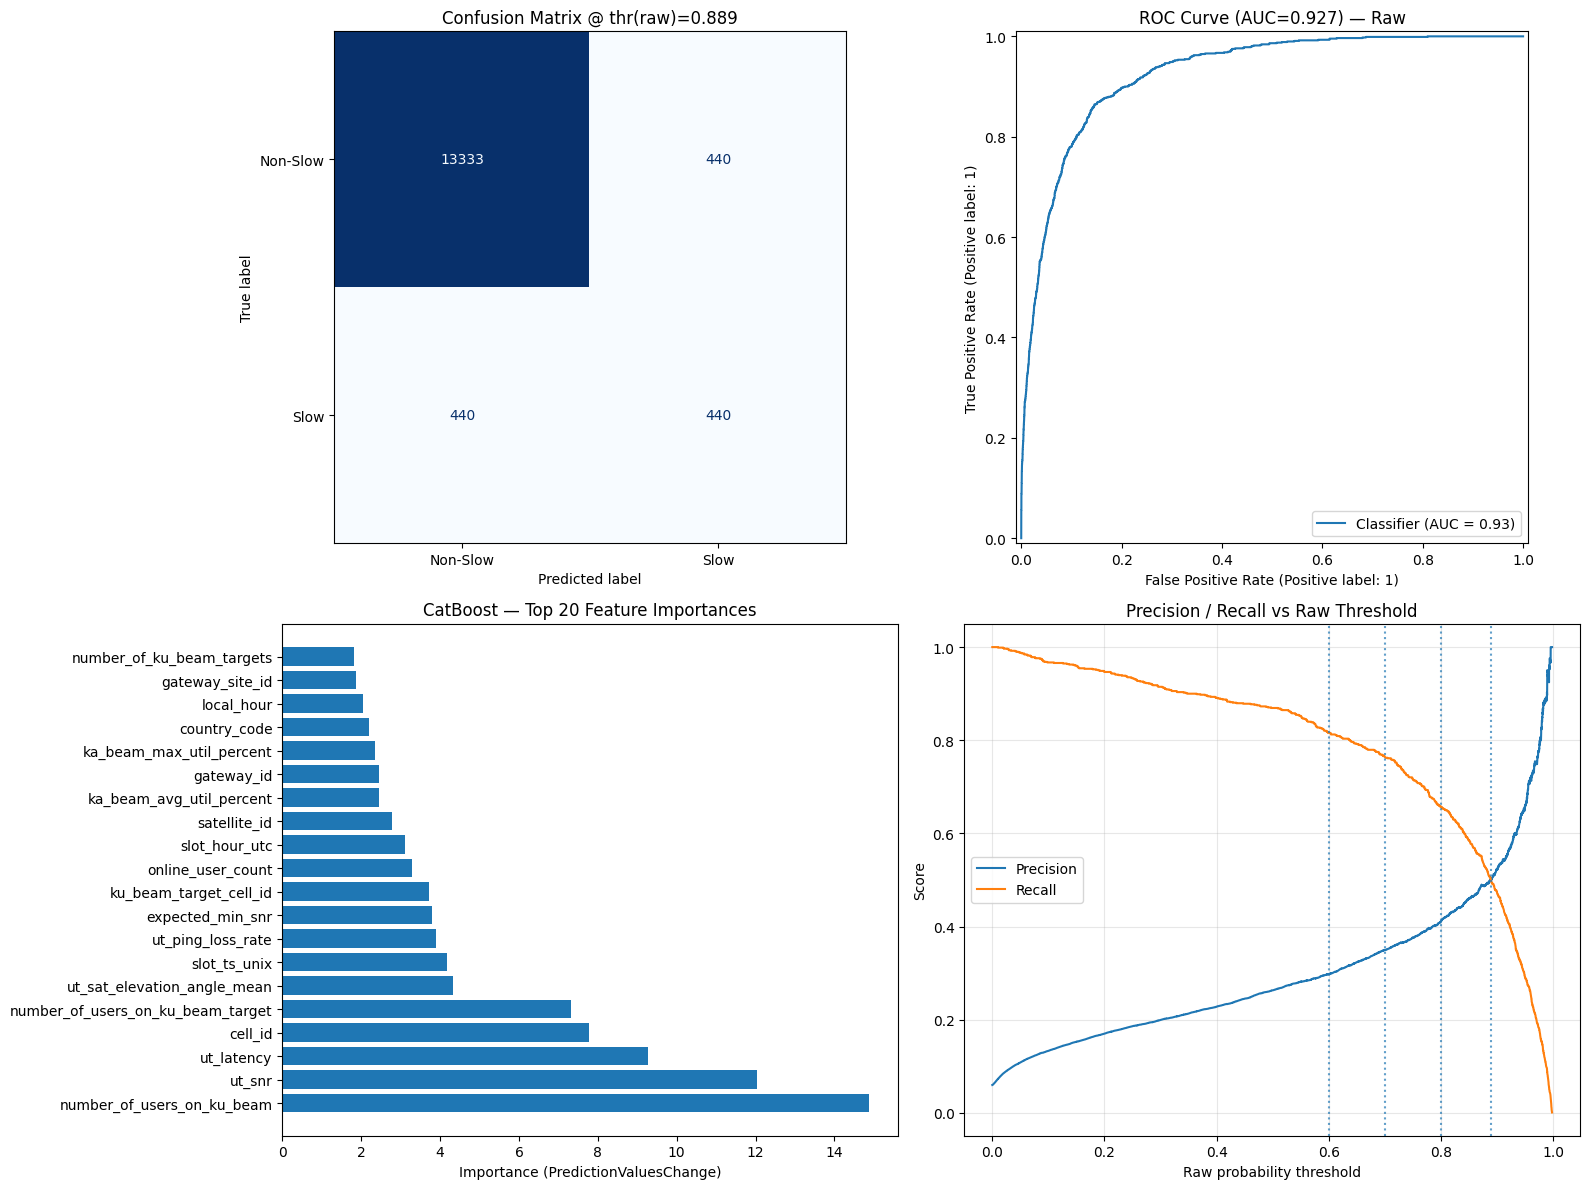

In [23]:
# ============================================================
#  CatBoost — diagnostics & plots (NO CALIBRATION)
# ============================================================


# ---- inputs from previous cell(s) ----
y_true = y_test.astype(int).values
feat_names = list(X_train_cb.columns)

# ---- use RAW CatBoost probabilities (no Platt, no isotonic) ----
proba_raw = proba_cb  # from the training cell

# ---- metrics & threshold selection (raw) ----
ap_raw  = average_precision_score(y_true, proba_raw)
roc_raw = roc_auc_score(y_true, proba_raw)

# Top-K equivalent (based on validation prevalence)
K = int(max(1, round(y_true.sum())))
chosen_thr = float(np.partition(proba_raw, -K)[-K]) if K < len(proba_raw) else float(proba_raw.min() - 1e-9)

y_hat = (proba_raw >= chosen_thr).astype(int)
cm = confusion_matrix(y_true, y_hat)
rep_txt = classification_report(y_true, y_hat, target_names=['Non-Slow','Slow'])

print("=============== CatBoost (RAW, UNCALIBRATED): VALID SUMMARY ===============")
print(f"PR-AUC={ap_raw:.4f}  ROC-AUC={roc_raw:.4f}")
print(f"Chosen threshold (raw)={chosen_thr:.4f}  (Top-K equiv, K={K})")
print("Confusion matrix @ chosen threshold:")
print(cm)
print("\nClassification report @ chosen threshold:")
print(rep_txt)

# ---- curves & threshold grid (raw) ----
prec, rec, thr = precision_recall_curve(y_true, proba_raw)
thr_grid = thr.copy()            # aligns with prec[:-1]/rec[:-1]
P_at_thr = prec[:-1]
R_at_thr = rec[:-1]

# ---- feature importances (CatBoost) ----
cb_importance = model_cb.get_feature_importance(type="PredictionValuesChange")
imp_df = pd.DataFrame({"feature": feat_names, "importance": cb_importance})
imp_df = imp_df.sort_values("importance", ascending=False).head(20)

# ---- plots ----
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# (1) Confusion Matrix @ chosen raw threshold
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Slow','Slow']).plot(
    ax=axs[0, 0], cmap='Blues', values_format='d', colorbar=False
)
axs[0, 0].set_title(f'Confusion Matrix @ thr(raw)={chosen_thr:.3f}')

# (2) ROC with raw probabilities
RocCurveDisplay.from_predictions(y_true, proba_raw, ax=axs[0, 1])
axs[0, 1].set_title(f'ROC Curve (AUC={roc_raw:.3f}) — Raw')

# (3) Precision & Recall vs Raw Threshold
axs[1, 1].plot(thr_grid, P_at_thr, label='Precision')
axs[1, 1].plot(thr_grid, R_at_thr, label='Recall')
for t in [0.6, 0.7, 0.8, chosen_thr]:
    axs[1, 1].axvline(x=t, linestyle=':', alpha=0.7)
axs[1, 1].set_xlabel('Raw probability threshold')
axs[1, 1].set_ylabel('Score')
axs[1, 1].set_title('Precision / Recall vs Raw Threshold')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

# (4) Top-20 feature importances
axs[1, 0].barh(range(len(imp_df)), imp_df['importance'][::-1])
axs[1, 0].set_yticks(range(len(imp_df)))
axs[1, 0].set_yticklabels(imp_df['feature'][::-1])
axs[1, 0].invert_yaxis()
axs[1, 0].set_xlabel('Importance (PredictionValuesChange)')
axs[1, 0].set_title('CatBoost — Top 20 Feature Importances')

plt.tight_layout()
plt.show()

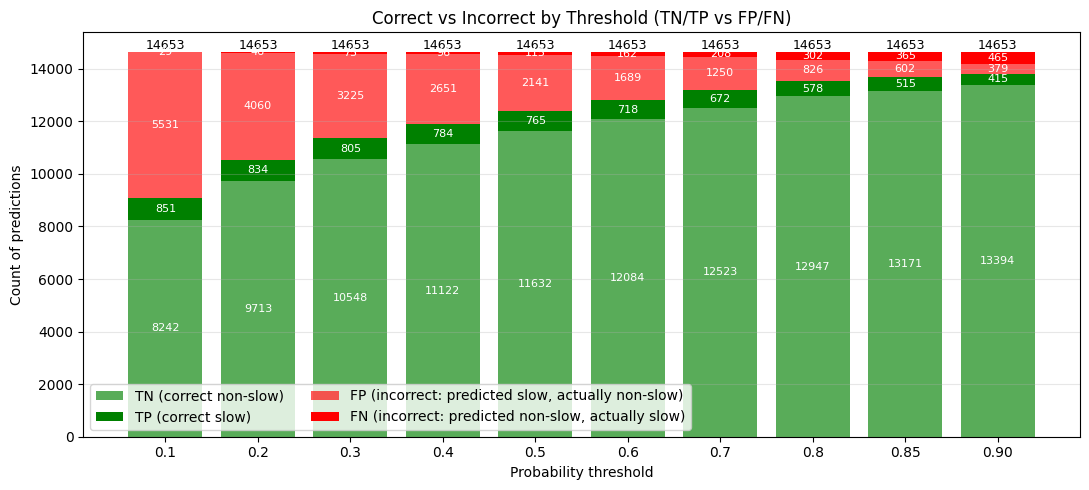

In [24]:
# ============================================================
#  TN / TP / FP / FN stacked bars by threshold
#  Bars at: 0.1, 0.2, ... 0.8, 0.85, 0.9
#  Colors: green=correct (TN, TP), red=incorrect (FP, FN)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Uses existing objects: y_true, proba_raw
thr_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.85,0.9]
n = len(y_true)

TN_list, TP_list, FP_list, FN_list = [], [], [], []
for t in thr_list:
    y_hat = (proba_raw >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    TN_list.append(int(tn))
    TP_list.append(int(tp))
    FP_list.append(int(fp))
    FN_list.append(int(fn))

x = np.arange(len(thr_list))
width = 0.8

plt.figure(figsize=(11,5))

# Bottom layer: TN (correct negatives)
bars_TN = plt.bar(x, TN_list, width=width, label='TN (correct non-slow)', color='green', alpha=0.65)

# Stack TP on top of TN (all correct = green stack)
tops_TNTP = np.array(TN_list)
bars_TP = plt.bar(x, TP_list, width=width, bottom=tops_TNTP, label='TP (correct slow)', color='green')

# Now stack FP (incorrect positives) on top of TN+TP
tops_TNTPFP = tops_TNTP + np.array(TP_list)
bars_FP = plt.bar(x, FP_list, width=width, bottom=tops_TNTPFP, label='FP (incorrect: predicted slow, actually non-slow)', color='red', alpha=0.65)

# Finally stack FN (incorrect negatives) on top of TN+TP+FP
tops_all = tops_TNTPFP + np.array(FP_list)
bars_FN = plt.bar(x, FN_list, width=width, bottom=tops_all, label='FN (incorrect: predicted non-slow, actually slow)', color='red')

# Optional: annotate totals on top and segment counts inside
for i in range(len(thr_list)):
    total = TN_list[i] + TP_list[i] + FP_list[i] + FN_list[i]
    # total label on top
    plt.text(x[i], total + max(1, 0.01*n)*0.01, str(total), ha='center', va='bottom', fontsize=9)
    # inner labels (comment out if noisy)
    if TN_list[i] > 0: plt.text(x[i], TN_list[i]/2, f"{TN_list[i]}", ha='center', va='center', fontsize=8, color='white')
    if TP_list[i] > 0: plt.text(x[i], TN_list[i] + TP_list[i]/2, f"{TP_list[i]}", ha='center', va='center', fontsize=8, color='white')
    if FP_list[i] > 0: plt.text(x[i], TN_list[i] + TP_list[i] + FP_list[i]/2, f"{FP_list[i]}", ha='center', va='center', fontsize=8, color='white')
    if FN_list[i] > 0: plt.text(x[i], TN_list[i] + TP_list[i] + FP_list[i] + FN_list[i]/2, f"{FN_list[i]}", ha='center', va='center', fontsize=8, color='white')

plt.xticks(x, [f"{t:.2f}" if t not in {0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8} else f"{t:.1f}" for t in thr_list])
plt.xlabel('Probability threshold')
plt.ylabel('Count of predictions')
plt.title('Correct vs Incorrect by Threshold (TN/TP vs FP/FN)')
plt.legend(ncol=2, frameon=True)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [25]:
# ============================================================
#   USE CATBOOST MODEL ON test_input_df (prod-safe)
# ============================================================

# ---- guardrails: make sure we have a trained CatBoost model ----
if 'model_cb' not in globals():
    raise RuntimeError("CatBoost model not found. Train `model_cb` first (see CatBoost block).")

# ---- 1) Build X_actual with the SAME preprocessing you used for train ----
X_actual = dtype_prep(test_input_df, possible_features=possible_features)

# ---- 2) Drop any datetime columns (CatBoost expects numerics/strings) ----
dt_cols = [c for c in X_actual.columns if is_datetime64_any_dtype(X_actual[c])]
if dt_cols:
    X_actual = X_actual.drop(columns=dt_cols)

# ---- 3) Reindex columns to match training EXACTLY (order matters) ----
X_actual = X_actual.reindex(columns=X_train.columns)

# ---- 4) CatBoost-safe categorical handling: cast to clean strings ----
# Identify cat cols from the TRAIN dtypes (authoritative)
cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) == 'category']

def to_cb_strings(df, cat_cols):
    X = df.copy()
    for c in cat_cols:
        # Cast to pandas string dtype, fill NaNs with sentinel, then to Python str
        X[c] = X[c].astype('string').fillna('__MISSING__').astype(str)
    return X

X_actual_cb = to_cb_strings(X_actual, cat_cols)

# Indices of categorical features in THIS frame (same order as columns)
cat_features_idx = [X_actual_cb.columns.get_loc(c) for c in cat_cols]

# ---- 5) Choose threshold (use Top-K equivalent if available; else 0.7) ----
_thr = float(globals().get('thr_equiv', 0.7))
print(f"Using CatBoost model | Prediction threshold: {_thr:.4f}")

# ---- 6) Predict on test_input_df ----
import catboost as cb
prod_pool    = cb.Pool(X_actual_cb, cat_features=cat_features_idx)
proba_actual = model_cb.predict_proba(prod_pool)[:, 1]
pred_actual  = (proba_actual >= _thr).astype(int)

# ---- 7) Build an output table (preserve some identifiers if present) ----
out_cols = []
for candidate in ['test_id', 'slot_timestamp', 'gateway_id', 'home_pop_id', 'satellite_id']:
    if candidate in test_input_df.columns and candidate not in out_cols:
        out_cols.append(candidate)

pred_df = pd.DataFrame({
    **({c: test_input_df[c].values for c in out_cols}),
    'pred_proba_slow': proba_actual,
    'pred_label_slow': pred_actual
})

# ---- 8) Preview ----
print("Preview of CatBoost prod predictions:")
display(pred_df.head(10))

# ---- 9) Export arrays if you need them later ----
y_pred_actual        = pred_actual
y_pred_proba_actual  = proba_actual


Using CatBoost model | Prediction threshold: 0.8887
Preview of CatBoost prod predictions:


,test_id,slot_timestamp,gateway_id,home_pop_id,satellite_id,pred_proba_slow,pred_label_slow
0,70001,2021-12-21T03:31:42Z,10620,101,2685,0.909554,1
1,70002,2021-12-21T03:31:27Z,10443,104,1867,0.041050,0
2,70003,2021-12-21T03:29:42Z,10536,101,1193,0.011745,0
3,70004,2021-12-21T15:33:57Z,10034,12,1955,0.002084,0
4,70005,2021-12-21T13:56:27Z,690,12,1393,0.000543,0
5,70006,2021-12-21T13:48:27Z,955,13,1216,0.001650,0
6,70007,2021-12-21T13:47:57Z,626,13,1687,0.002821,0


# Analysis of Slowest Satellites, Gateways, and PoPs

## Satellites

In [26]:
df.columns

Index(['router_speedtest_tcp_64_download_Mbps_avg', 'slot_timestamp',
       'ut_ping_loss_rate', 'cell_id', 'home_pop_id', 'gateway_id',
       'satellite_id', 'ut_snr', 'expected_min_snr', 'ut_latency',
       'link_failure_detected', 'ut_sat_elevation_angle_mean',
       'number_of_ku_beam_targets', 'number_of_users_on_ku_beam',
       'number_of_users_on_ku_beam_target', 'ku_beam_target_cell_id',
       'local_hour', 'country_code', 'test_id', 'slot_timestamp_dt',
       'time_bin', 'gateway_site_id', 'online_user_count',
       'ka_beam_avg_util_percent', 'ka_beam_max_util_percent',
       'ka_beam_active_count', '_merge', 'slow_speed', 'ut_snr__isna',
       'ut_latency__isna', 'expected_min_snr__isna',
       'number_of_users_on_ku_beam__isna'],
      dtype='object')

=== Slowest satellites (by within-satellite slow proportion) ===


,slow_cnt,N_s,non_slow_cnt,slow_prop,slow_to_non
satellite_id,,,,,
2375,14,61,47,0.229508,0.297872
2356,8,35,27,0.228571,0.296296
2270,16,84,68,0.190476,0.235294
1076,4,22,18,0.181818,0.222222
1882,4,22,18,0.181818,0.222222
1699,13,72,59,0.180556,0.220339
1749,16,90,74,0.177778,0.216216
1577,6,34,28,0.176471,0.214286
1944,4,23,19,0.173913,0.210526



=== Fastest satellites (excluding slowest set) ===


,slow_cnt,N_s,non_slow_cnt,slow_prop,slow_to_non
satellite_id,,,,,
1718,0,94,94,0.0,0.0
1062,0,84,84,0.0,0.0
2483,0,84,84,0.0,0.0
2132,0,74,74,0.0,0.0
2378,0,74,74,0.0,0.0
1612,0,68,68,0.0,0.0
1810,0,68,68,0.0,0.0
1013,0,61,61,0.0,0.0
2733,0,54,54,0.0,0.0



=== online_user_count — numeric summaries (satellites) ===
SLOWEST satellites:
       n: 1101
    mean: 1475.58310626703
     std: 882.6871162153235
     min: 1.0
     p05: 301.0
     p25: 877.0
  median: 1331.0
     p75: 1884.0
     p95: 3325.0
     max: 4692.0
FASTEST satellites:
       n: 1042
    mean: 1301.6094049904032
     std: 774.2569069448506
     min: 1.0
     p05: 244.10000000000002
     p25: 746.25
  median: 1152.0
     p75: 1730.25
     p95: 2759.7499999999995
     max: 3965.0
Two-sample tests:
  KS:  statistic=0.1190, p-value=4.504e-07
  MWU: U=640297, p-value=3.207e-06

=== ka_beam_avg_util_percent — numeric summaries (satellites) ===
SLOWEST satellites:
       n: 1100
    mean: 41.33090909090909
     std: 22.24664351063893
     min: 2.0
     p05: 11.0
     p25: 24.0
  median: 37.0
     p75: 57.0
     p95: 84.0
     max: 99.0
FASTEST satellites:
       n: 1042
    mean: 40.7341650671785
     std: 23.487183819459418
     min: 0.0
     p05: 9.0
     p25: 22.0
  median: 3

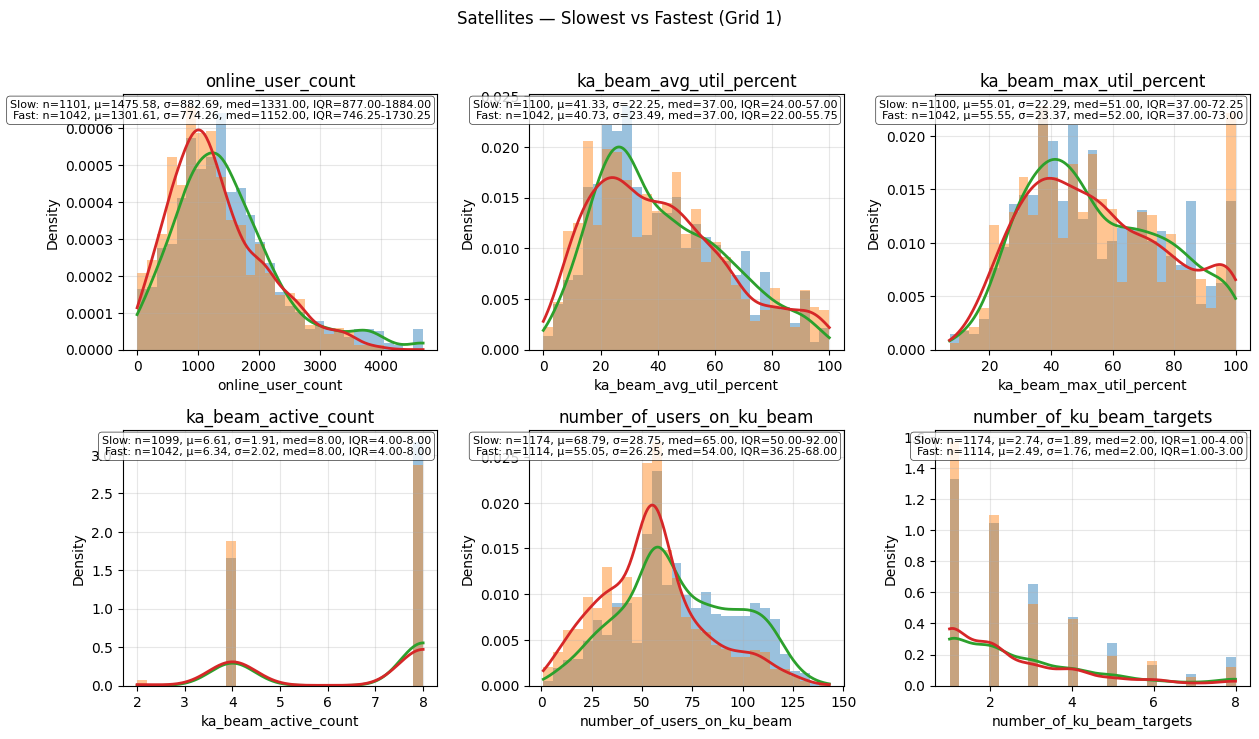

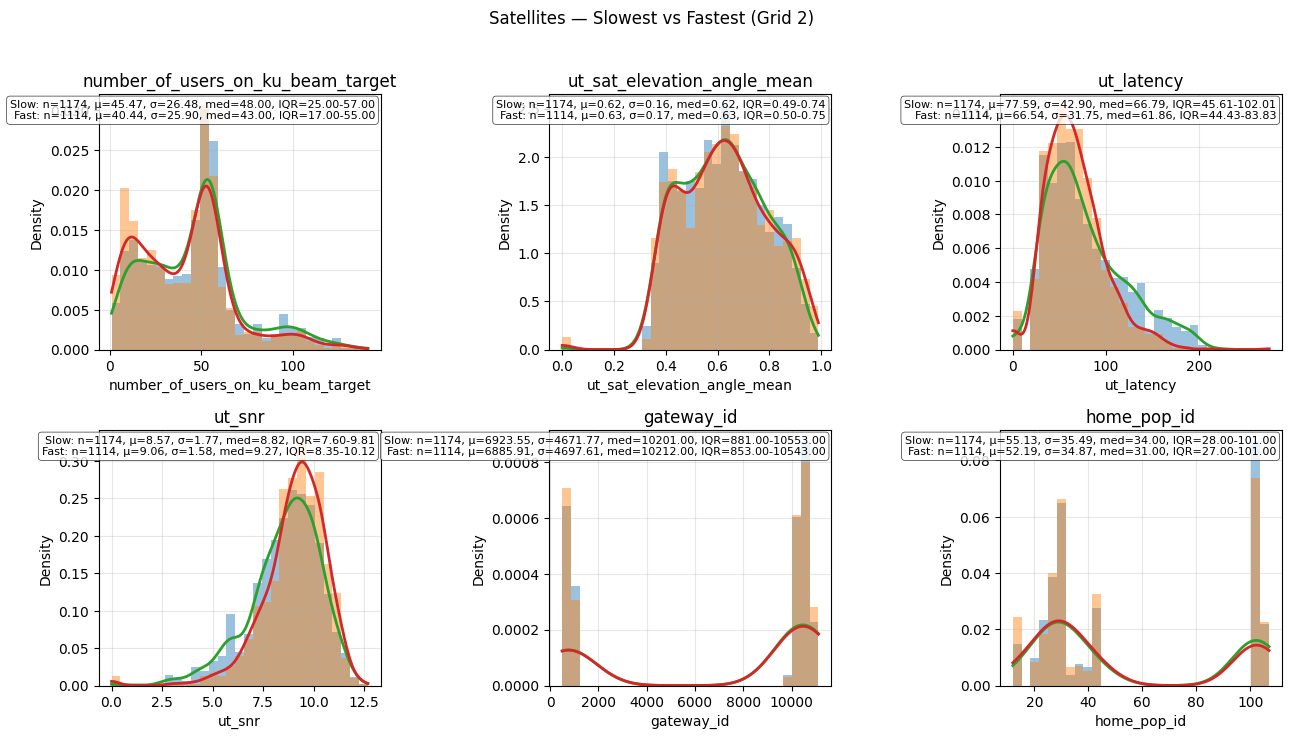

In [27]:
# ============================================================
# Satellites: slowest vs fastest + overlaid histograms w/ KDE
#  - Entity: satellite_id
#  - "Slow" = router_speedtest_tcp_64_download_Mbps_avg < 50
#  - Picks TOP_K slowest satellites by slow proportion (N_s ≥ MIN_SAMPLES),
#    and a disjoint set of TOP_K fastest satellites.
#  - For each metric: prints summaries + KS/MWU; plots OVERLAID hist + KDE
#    in two big subplot grids.
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, mannwhitneyu, gaussian_kde
import math

# -------------------------
# 1) Parameters
# -------------------------
SPEED_COL   = 'router_speedtest_tcp_64_download_Mbps_avg'
SAT_COL     = 'satellite_id'
MIN_SAMPLES = 20
TOP_K       = 20

# Metrics to visualize; any missing ones will be skipped safely
METRICS = [
    'online_user_count',
    'ka_beam_avg_util_percent',
    'ka_beam_max_util_percent',
    'ka_beam_active_count',
    'number_of_users_on_ku_beam',
    'number_of_ku_beam_targets',
    'number_of_users_on_ku_beam_target',
    'ut_sat_elevation_angle_mean',
    'ut_latency',
    'ut_snr',

    'gateway_id',
    'home_pop_id',

]

# -------------------------
# 2) Build per-satellite slow stats
# -------------------------
df_sat = df[[SPEED_COL, SAT_COL]].copy()
df_sat['is_slow']   = pd.to_numeric(df_sat[SPEED_COL], errors='coerce') < 50
df_sat[SAT_COL]     = df_sat[SAT_COL].astype('string')

sat_stats = (df_sat.dropna(subset=[SAT_COL, SPEED_COL])
             .groupby(SAT_COL)['is_slow']
             .agg(slow_cnt='sum', N_s='size')
             .assign(non_slow_cnt=lambda t: t.N_s - t.slow_cnt,
                     slow_prop   =lambda t: t.slow_cnt / t.N_s,
                     slow_to_non =lambda t: t.slow_cnt / t.non_slow_cnt.replace(0, np.nan))
             .query('N_s >= @MIN_SAMPLES'))

slowest_sat = (sat_stats.sort_values(['slow_prop','N_s'], ascending=[False, False])
                        .head(TOP_K))
slowest_sat_ids = set(slowest_sat.index.astype(str))

fastest_sat = (sat_stats[~sat_stats.index.astype(str).isin(slowest_sat_ids)]
               .sort_values(['slow_prop','N_s'], ascending=[True, False])
               .head(len(slowest_sat)))
fastest_sat_ids = set(fastest_sat.index.astype(str))

print("=== Slowest satellites (by within-satellite slow proportion) ===")
display(slowest_sat)
print("\n=== Fastest satellites (excluding slowest set) ===")
display(fastest_sat)

# -------------------------
# 3) Helpers
# -------------------------
def _summ(v):
    v = pd.to_numeric(pd.Series(v), errors='coerce').dropna().values
    if v.size == 0:
        return {"n": 0}
    q = np.percentile(v, [5,25,50,75,95])
    return {
        "n": int(v.size),
        "mean": float(v.mean()),
        "std": float(v.std(ddof=1)) if v.size > 1 else np.nan,
        "min": float(v.min()),
        "p05": float(q[0]),
        "p25": float(q[1]),
        "median": float(q[2]),
        "p75": float(q[3]),
        "p95": float(q[4]),
        "max": float(v.max())
    }

def _fmt_stats(tag, d):
    if d.get("n", 0) == 0:
        return f"{tag}: n=0"
    return (f"{tag}: n={d['n']}, μ={d['mean']:.2f}, σ={d['std']:.2f}, "
            f"med={d['median']:.2f}, IQR={d['p25']:.2f}-{d['p75']:.2f}")

sid = df[SAT_COL].astype(str)
slow_mask_sat = sid.isin(slowest_sat_ids)
fast_mask_sat = sid.isin(fastest_sat_ids)

# -------------------------
# 4) Numeric summaries + tests for each metric
# -------------------------
for col in METRICS:
    if col not in df.columns:
        print(f"\n[SKIP] Column missing: {col}")
        continue
    slow_vals = pd.to_numeric(df.loc[slow_mask_sat, col], errors='coerce').dropna().values
    fast_vals = pd.to_numeric(df.loc[fast_mask_sat, col], errors='coerce').dropna().values

    print(f"\n=== {col} — numeric summaries (satellites) ===")
    sstats = _summ(slow_vals); fstats = _summ(fast_vals)
    print("SLOWEST satellites:")
    for k,v in sstats.items(): print(f"  {k:>6}: {v}")
    print("FASTEST satellites:")
    for k,v in fstats.items(): print(f"  {k:>6}: {v}")

    if slow_vals.size and fast_vals.size:
        ks = ks_2samp(slow_vals, fast_vals, alternative='two-sided', mode='auto')
        mwu = mannwhitneyu(slow_vals, fast_vals, alternative='two-sided')
        print("Two-sample tests:")
        print(f"  KS:  statistic={ks.statistic:.4f}, p-value={ks.pvalue:.3e}")
        print(f"  MWU: U={mwu.statistic:.0f}, p-value={mwu.pvalue:.3e}")

# -------------------------
# 5) Big subplot grids: overlaid hist + KDE per metric
# -------------------------
def _plot_grid(metrics, ncols=3, suptitle="Sat metrics — Slowest vs Fastest"):
    # Filter to present metrics
    metrics = [m for m in metrics if m in df.columns]
    if not metrics:
        print("[No metrics to plot]")
        return

    n = len(metrics)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.3*ncols, 3.6*nrows), squeeze=False, sharex=False, sharey=False)
    ax_iter = iter(axes.flatten())

    for i, col in enumerate(metrics):
        ax = next(ax_iter)

        slow_vals = pd.to_numeric(df.loc[slow_mask_sat, col], errors='coerce').dropna().values
        fast_vals = pd.to_numeric(df.loc[fast_mask_sat, col], errors='coerce').dropna().values

        # Determine common bins
        both = np.concatenate([slow_vals, fast_vals]) if (slow_vals.size and fast_vals.size) \
               else (slow_vals if slow_vals.size else fast_vals)
        if both.size and np.nanmin(both) != np.nanmax(both):
            bins = np.linspace(np.nanmin(both), np.nanmax(both), 30)
        else:
            bins = 10

        # Overlaid hists
        ax.hist(slow_vals, bins=bins, density=True, alpha=0.45, label='Slowest sats')
        ax.hist(fast_vals, bins=bins, density=True, alpha=0.45, label='Fastest sats')

        # KDE curves
        try:
            xs = None
            if slow_vals.size > 1 and np.nanstd(slow_vals) > 0:
                xs = np.linspace(np.nanmin(both), np.nanmax(both), 256)
                ax.plot(xs, gaussian_kde(slow_vals)(xs), linewidth=2)
            if fast_vals.size > 1 and np.nanstd(fast_vals) > 0:
                if xs is None:
                    xs = np.linspace(np.nanmin(both), np.nanmax(both), 256)
                ax.plot(xs, gaussian_kde(fast_vals)(xs), linewidth=2)
        except Exception:
            pass

        # Small on-axes stats box
        sstats = _summ(slow_vals); fstats = _summ(fast_vals)
        txt = _fmt_stats("Slow", sstats) + "\n" + _fmt_stats("Fast", fstats)
        ax.text(0.98, 0.98, txt, ha='right', va='top', fontsize=8,
                transform=ax.transAxes,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, lw=0.5))

        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.grid(alpha=0.3)

    # Hide any leftover empty axes
    for ax in ax_iter:
        ax.axis('off')

    fig.suptitle(suptitle, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# Split into two grids to avoid a single mega-figure being cramped
half = math.ceil(len(METRICS)/2)
_plot_grid(METRICS[:half], ncols=3, suptitle="Satellites — Slowest vs Fastest (Grid 1)")
_plot_grid(METRICS[half:], ncols=3, suptitle="Satellites — Slowest vs Fastest (Grid 2)")


## Gateways

=== Slowest gateways (by within-gateway slow proportion) ===


,slow_cnt,N_g,non_slow_cnt,slow_prop,slow_to_non
gateway_id,,,,,
10274,9,37,28,0.243243,0.321429
10930,49,208,159,0.235577,0.308176
10277,9,39,30,0.230769,0.300000
10513,6,26,20,0.230769,0.300000
11028,9,43,34,0.209302,0.264706
979,31,149,118,0.208054,0.262712
10444,30,145,115,0.206897,0.260870
10447,25,121,96,0.206612,0.260417
10933,37,185,148,0.200000,0.250000



=== Fastest gateways (excluding slowest set) ===


,slow_cnt,N_g,non_slow_cnt,slow_prop,slow_to_non
gateway_id,,,,,
853,0,198,198,0.0,0.0
633,0,191,191,0.0,0.0
10488,0,152,152,0.0,0.0
861,0,123,123,0.0,0.0
804,0,118,118,0.0,0.0
10326,0,110,110,0.0,0.0
818,0,105,105,0.0,0.0
971,0,100,100,0.0,0.0
931,0,99,99,0.0,0.0



=== online_user_count — numeric summaries (gateways) ===
SLOWEST gateways:
       n: 2765
    mean: 2323.671247739602
     std: 985.5769274610839
     min: 1.0
     p05: 845.4000000000001
     p25: 1630.0
  median: 2160.0
     p75: 3020.0
     p95: 4052.0
     max: 4987.0
FASTEST gateways:
       n: 1886
    mean: 809.4639448568398
     std: 495.53394777179216
     min: 1.0
     p05: 167.0
     p25: 444.25
  median: 736.5
     p75: 1067.0
     p95: 1809.5
     max: 2977.0
Two-sample tests:
  KS:  statistic=0.7363, p-value=0.000e+00
  MWU: U=4811324, p-value=0.000e+00

=== ka_beam_avg_util_percent — numeric summaries (gateways) ===
SLOWEST gateways:
       n: 2765
    mean: 60.747920433996384
     std: 23.17673633813536
     min: 0.0
     p05: 23.0
     p25: 41.0
  median: 63.0
     p75: 80.0
     p95: 95.0
     max: 100.0
FASTEST gateways:
       n: 1886
    mean: 21.589077412513255
     std: 14.127095229587518
     min: 0.0
     p05: 5.0
     p25: 11.0
  median: 18.0
     p75: 29.0
 

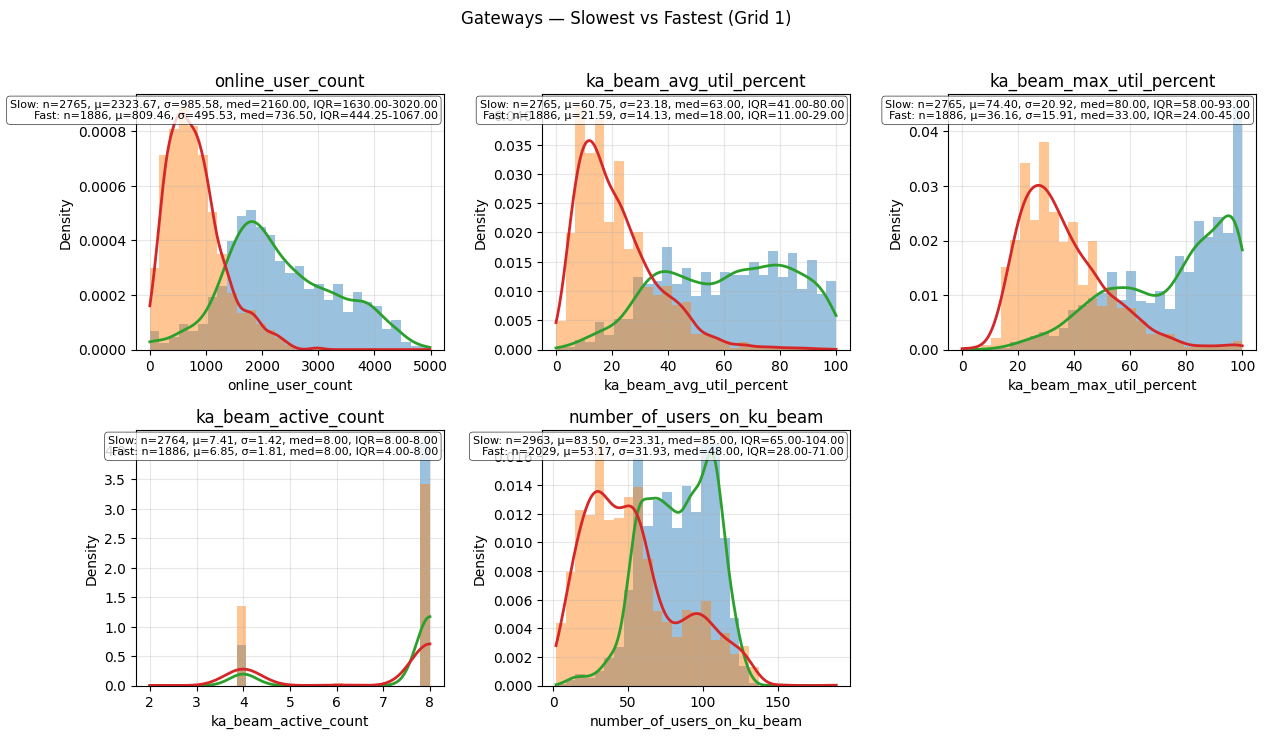

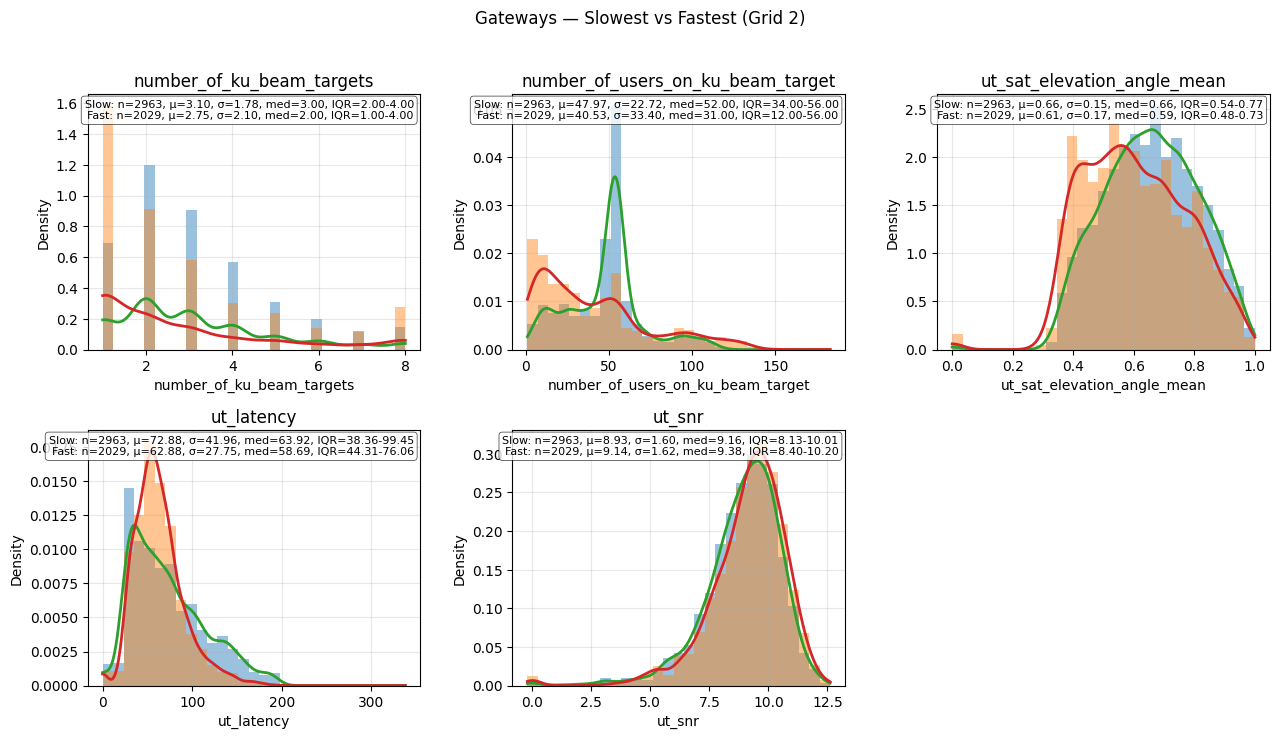

In [28]:
# ============================================================
# Gateways: slowest vs fastest + overlaid histograms w/ KDE
#  - Entity: gateway_id
#  - "Slow" = router_speedtest_tcp_64_download_Mbps_avg < 50
#  - Select TOP_K slowest gateways by slow proportion (N_g ≥ MIN_SAMPLES),
#    and a disjoint set of TOP_K fastest gateways.
#  - For each metric: prints summaries + KS/MWU; plots OVERLAID hist + KDE
#    in two big subplot grids with on-axes stats boxes.
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, mannwhitneyu, gaussian_kde
import math

# -------------------------
# 1) Parameters
# -------------------------
SPEED_COL   = 'router_speedtest_tcp_64_download_Mbps_avg'
GATE_COL    = 'gateway_id'
MIN_SAMPLES = 20
TOP_K       = 20

# Metrics to visualize; any missing ones will be skipped safely
# Metrics to visualize; any missing ones will be skipped safely
METRICS = [
    'online_user_count',
    'ka_beam_avg_util_percent',
    'ka_beam_max_util_percent',
    'ka_beam_active_count',
    'number_of_users_on_ku_beam',
    'number_of_ku_beam_targets',
    'number_of_users_on_ku_beam_target',
    'ut_sat_elevation_angle_mean',
    'ut_latency',
    'ut_snr',

    # 'gateway_id',
    # 'satellite_id',
    # 'home_pop_id',

]

# -------------------------
# 2) Build per-gateway slow stats
# -------------------------
df_gate = df[[SPEED_COL, GATE_COL]].copy()
df_gate['is_slow']  = pd.to_numeric(df_gate[SPEED_COL], errors='coerce') < 50
df_gate[GATE_COL]   = df_gate[GATE_COL].astype('string')

gate_stats = (df_gate.dropna(subset=[GATE_COL, SPEED_COL])
              .groupby(GATE_COL)['is_slow']
              .agg(slow_cnt='sum', N_g='size')
              .assign(non_slow_cnt=lambda t: t.N_g - t.slow_cnt,
                      slow_prop   =lambda t: t.slow_cnt / t.N_g,
                      slow_to_non =lambda t: t.slow_cnt / t.non_slow_cnt.replace(0, np.nan))
              .query('N_g >= @MIN_SAMPLES'))

slowest_gate = (gate_stats.sort_values(['slow_prop','N_g'], ascending=[False, False])
                         .head(TOP_K))
slowest_gate_ids = set(slowest_gate.index.astype(str))

fastest_gate = (gate_stats[~gate_stats.index.astype(str).isin(slowest_gate_ids)]
                .sort_values(['slow_prop','N_g'], ascending=[True, False])
                .head(len(slowest_gate)))
fastest_gate_ids = set(fastest_gate.index.astype(str))

print("=== Slowest gateways (by within-gateway slow proportion) ===")
display(slowest_gate)
print("\n=== Fastest gateways (excluding slowest set) ===")
display(fastest_gate)

# -------------------------
# 3) Helpers
# -------------------------
def _summ(v):
    v = pd.to_numeric(pd.Series(v), errors='coerce').dropna().values
    if v.size == 0:
        return {"n": 0}
    q = np.percentile(v, [5,25,50,75,95])
    return {
        "n": int(v.size),
        "mean": float(v.mean()),
        "std": float(v.std(ddof=1)) if v.size > 1 else np.nan,
        "min": float(v.min()),
        "p05": float(q[0]),
        "p25": float(q[1]),
        "median": float(q[2]),
        "p75": float(q[3]),
        "p95": float(q[4]),
        "max": float(v.max())
    }

def _fmt_stats(tag, d):
    if d.get("n", 0) == 0:
        return f"{tag}: n=0"
    return (f"{tag}: n={d['n']}, μ={d['mean']:.2f}, σ={d['std']:.2f}, "
            f"med={d['median']:.2f}, IQR={d['p25']:.2f}-{d['p75']:.2f}")

gid = df[GATE_COL].astype(str)
slow_mask_gate = gid.isin(slowest_gate_ids)
fast_mask_gate = gid.isin(fastest_gate_ids)

# -------------------------
# 4) Numeric summaries + tests for each metric
# -------------------------
for col in METRICS:
    if col not in df.columns:
        print(f"\n[SKIP] Column missing: {col}")
        continue

    slow_vals = pd.to_numeric(df.loc[slow_mask_gate, col], errors='coerce').dropna().values
    fast_vals = pd.to_numeric(df.loc[fast_mask_gate, col], errors='coerce').dropna().values

    print(f"\n=== {col} — numeric summaries (gateways) ===")
    sstats = _summ(slow_vals); fstats = _summ(fast_vals)
    print("SLOWEST gateways:")
    for k,v in sstats.items(): print(f"  {k:>6}: {v}")
    print("FASTEST gateways:")
    for k,v in fstats.items(): print(f"  {k:>6}: {v}")

    if slow_vals.size and fast_vals.size:
        ks = ks_2samp(slow_vals, fast_vals, alternative='two-sided', mode='auto')
        mwu = mannwhitneyu(slow_vals, fast_vals, alternative='two-sided')
        print("Two-sample tests:")
        print(f"  KS:  statistic={ks.statistic:.4f}, p-value={ks.pvalue:.3e}")
        print(f"  MWU: U={mwu.statistic:.0f}, p-value={mwu.pvalue:.3e}")

# -------------------------
# 5) Big subplot grids: overlaid hist + KDE per metric
# -------------------------
def _plot_grid(metrics, ncols=3, suptitle="Gateway metrics — Slowest vs Fastest"):
    metrics = [m for m in metrics if m in df.columns]
    if not metrics:
        print("[No metrics to plot]")
        return

    n = len(metrics)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.3*ncols, 3.6*nrows), squeeze=False)
    ax_iter = iter(axes.flatten())

    for col in metrics:
        ax = next(ax_iter)

        slow_vals = pd.to_numeric(df.loc[slow_mask_gate, col], errors='coerce').dropna().values
        fast_vals = pd.to_numeric(df.loc[fast_mask_gate, col], errors='coerce').dropna().values

        # Determine common bins
        both = np.concatenate([slow_vals, fast_vals]) if (slow_vals.size and fast_vals.size) \
               else (slow_vals if slow_vals.size else fast_vals)
        if both.size and np.nanmin(both) != np.nanmax(both):
            bins = np.linspace(np.nanmin(both), np.nanmax(both), 30)
        else:
            bins = 10

        # Overlaid histograms
        ax.hist(slow_vals, bins=bins, density=True, alpha=0.45, label='Slowest gateways')
        ax.hist(fast_vals, bins=bins, density=True, alpha=0.45, label='Fastest gateways')

        # KDE curves (guard for degenerate cases)
        try:
            xs = None
            if slow_vals.size > 1 and np.nanstd(slow_vals) > 0:
                xs = np.linspace(np.nanmin(both), np.nanmax(both), 256)
                ax.plot(xs, gaussian_kde(slow_vals)(xs), linewidth=2)
            if fast_vals.size > 1 and np.nanstd(fast_vals) > 0:
                if xs is None:
                    xs = np.linspace(np.nanmin(both), np.nanmax(both), 256)
                ax.plot(xs, gaussian_kde(fast_vals)(xs), linewidth=2)
        except Exception:
            pass

        # On-axes stats box
        sstats = _summ(slow_vals); fstats = _summ(fast_vals)
        txt = _fmt_stats("Slow", sstats) + "\n" + _fmt_stats("Fast", fstats)
        ax.text(0.98, 0.98, txt, ha='right', va='top', fontsize=8,
                transform=ax.transAxes,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, lw=0.5))

        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.grid(alpha=0.3)

    # Hide any leftover empty axes
    for ax in ax_iter:
        ax.axis('off')

    fig.suptitle(suptitle, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# Split across two grids for readability
half = math.ceil(len(METRICS)/2)
_plot_grid(METRICS[:half], ncols=3, suptitle="Gateways — Slowest vs Fastest (Grid 1)")
_plot_grid(METRICS[half:], ncols=3, suptitle="Gateways — Slowest vs Fastest (Grid 2)")


## PoPs

=== Slowest PoPs (by within-PoP slow proportion) ===


,slow_cnt,N_p,non_slow_cnt,slow_prop,slow_to_non
home_pop_id,,,,,
22,192,759,567,0.252964,0.338624
30,792,6207,5415,0.127598,0.146260
23,108,1022,914,0.105675,0.118162
103,280,3129,2849,0.089485,0.098280
101,1315,15762,14447,0.083428,0.091022
21,116,1449,1333,0.080055,0.087022
43,160,2443,2283,0.065493,0.070083
38,78,1331,1253,0.058603,0.062251
35,30,523,493,0.057361,0.060852



=== Fastest PoPs (excluding slowest set) ===


,slow_cnt,N_p,non_slow_cnt,slow_prop,slow_to_non
home_pop_id,,,,,
106,0,39,39,0.000000,0.000000
105,0,36,36,0.000000,0.000000
26,3,1411,1408,0.002126,0.002131
25,2,505,503,0.003960,0.003976
19,4,466,462,0.008584,0.008658
15,11,763,752,0.014417,0.014628
27,108,5571,5463,0.019386,0.019769
12,124,4918,4794,0.025214,0.025866



=== online_user_count — numeric summaries (PoPs) ===
SLOWEST PoPs:
       n: 55689
    mean: 1461.1822622061807
     std: 825.8054944265198
     min: 1.0
     p05: 348.0
     p25: 878.0
  median: 1325.0
     p75: 1901.0
     p95: 3105.0
     max: 5078.0
FASTEST PoPs:
       n: 12666
    mean: 796.2893573345965
     std: 545.4327502070718
     min: 1.0
     p05: 104.0
     p25: 389.0
  median: 705.0
     p75: 1075.0
     p95: 1850.75
     max: 4192.0
Two-sample tests:
  KS:  statistic=0.3942, p-value=0.000e+00
  MWU: U=535135346, p-value=0.000e+00

=== ka_beam_avg_util_percent — numeric summaries (PoPs) ===
SLOWEST PoPs:
       n: 55674
    mean: 44.531702410460895
     std: 23.358834070890474
     min: 0.0
     p05: 12.0
     p25: 26.0
  median: 41.0
     p75: 61.0
     p95: 89.0
     max: 100.0
FASTEST PoPs:
       n: 12663
    mean: 21.83068783068783
     std: 16.142639818367986
     min: 0.0
     p05: 4.0
     p25: 10.0
  median: 18.0
     p75: 28.0
     p95: 54.0
     max: 99.0
Tw

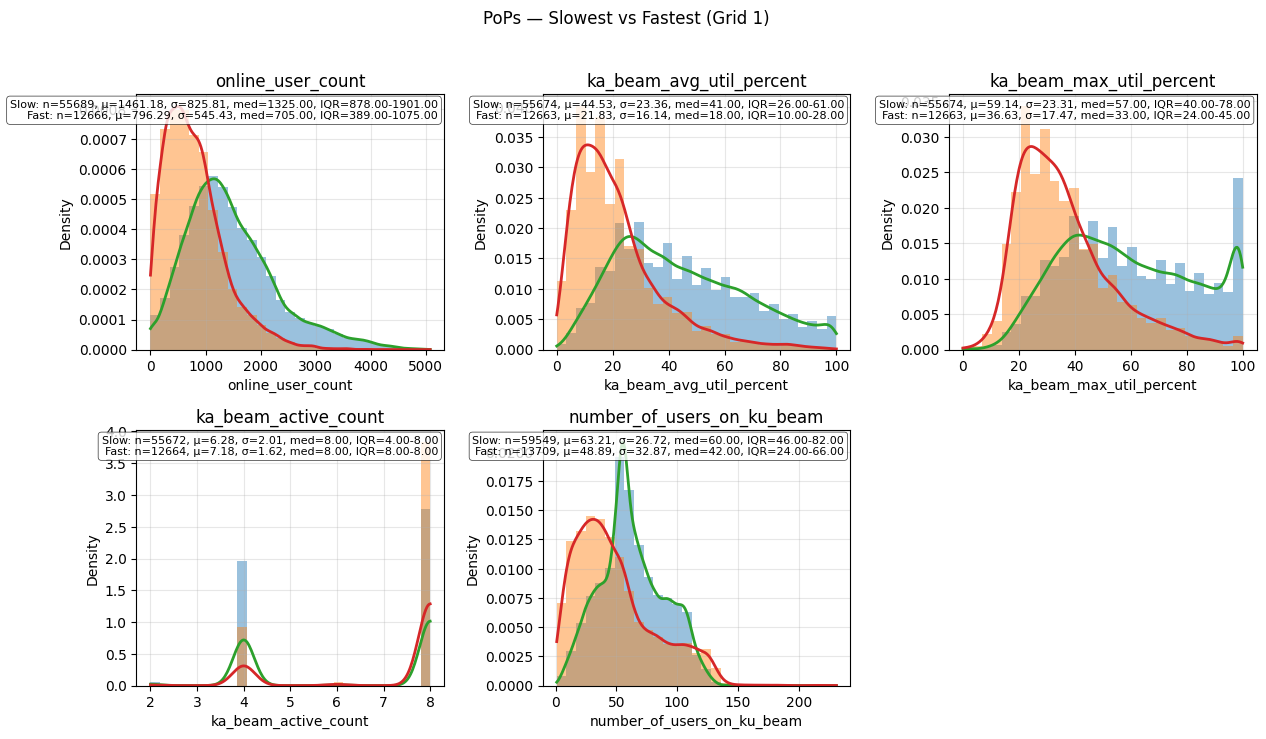

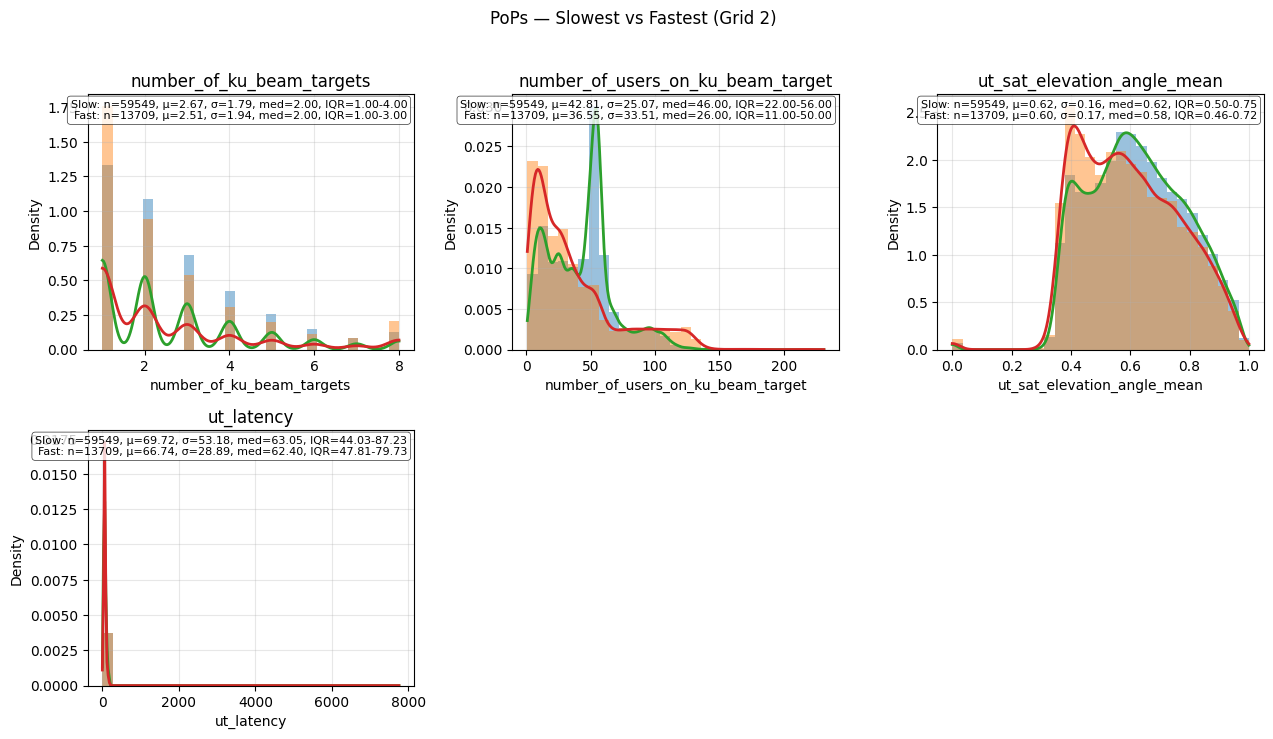

In [29]:
# ============================================================
# PoPs: slowest vs fastest + overlaid histograms w/ KDE
#  - Entity: home_pop_id
#  - "Slow" = router_speedtest_tcp_64_download_Mbps_avg < 50
#  - Select TOP_K slowest PoPs by slow proportion (N_p ≥ MIN_SAMPLES),
#    and a disjoint set of TOP_K fastest PoPs.
#  - For each metric: prints summaries + KS/MWU; plots OVERLAID hist + KDE
#    in two big subplot grids with on-axes stats boxes.
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, mannwhitneyu, gaussian_kde
import math

# -------------------------
# 1) Parameters
# -------------------------
SPEED_COL   = 'router_speedtest_tcp_64_download_Mbps_avg'
POP_COL     = 'home_pop_id'
MIN_SAMPLES = 20
TOP_K       = 20

# Metrics to visualize; any missing ones will be skipped safely
METRICS = [
    'online_user_count',
    'ka_beam_avg_util_percent',
    'ka_beam_max_util_percent',
    'ka_beam_active_count',
    'number_of_users_on_ku_beam',
    'number_of_ku_beam_targets',
    'number_of_users_on_ku_beam_target',
    'ut_sat_elevation_angle_mean',
    'ut_latency',
]

# -------------------------
# 2) Build per-PoP slow stats
# -------------------------
df_pop = df[[SPEED_COL, POP_COL]].copy()
df_pop['is_slow']  = pd.to_numeric(df_pop[SPEED_COL], errors='coerce') < 50
df_pop[POP_COL]    = df_pop[POP_COL].astype('string')

pop_stats = (df_pop.dropna(subset=[POP_COL, SPEED_COL])
             .groupby(POP_COL)['is_slow']
             .agg(slow_cnt='sum', N_p='size')
             .assign(non_slow_cnt=lambda t: t.N_p - t.slow_cnt,
                     slow_prop   =lambda t: t.slow_cnt / t.N_p,
                     slow_to_non =lambda t: t.slow_cnt / t.non_slow_cnt.replace(0, np.nan))
             .query('N_p >= @MIN_SAMPLES'))

slowest_pop = (pop_stats.sort_values(['slow_prop','N_p'], ascending=[False, False])
                        .head(TOP_K))
slowest_pop_ids = set(slowest_pop.index.astype(str))

fastest_pop = (pop_stats[~pop_stats.index.astype(str).isin(slowest_pop_ids)]
               .sort_values(['slow_prop','N_p'], ascending=[True, False])
               .head(len(slowest_pop)))
fastest_pop_ids = set(fastest_pop.index.astype(str))

print("=== Slowest PoPs (by within-PoP slow proportion) ===")
display(slowest_pop)
print("\n=== Fastest PoPs (excluding slowest set) ===")
display(fastest_pop)

# -------------------------
# 3) Helpers
# -------------------------
def _summ(v):
    v = pd.to_numeric(pd.Series(v), errors='coerce').dropna().values
    if v.size == 0:
        return {"n": 0}
    q = np.percentile(v, [5,25,50,75,95])
    return {
        "n": int(v.size),
        "mean": float(v.mean()),
        "std": float(v.std(ddof=1)) if v.size > 1 else np.nan,
        "min": float(v.min()),
        "p05": float(q[0]),
        "p25": float(q[1]),
        "median": float(q[2]),
        "p75": float(q[3]),
        "p95": float(q[4]),
        "max": float(v.max())
    }

def _fmt_stats(tag, d):
    if d.get("n", 0) == 0:
        return f"{tag}: n=0"
    return (f"{tag}: n={d['n']}, μ={d['mean']:.2f}, σ={d['std']:.2f}, "
            f"med={d['median']:.2f}, IQR={d['p25']:.2f}-{d['p75']:.2f}")

pid = df[POP_COL].astype(str)
slow_mask_pop = pid.isin(slowest_pop_ids)
fast_mask_pop = pid.isin(fastest_pop_ids)

# -------------------------
# 4) Numeric summaries + tests for each metric
# -------------------------
for col in METRICS:
    if col not in df.columns:
        print(f"\n[SKIP] Column missing: {col}")
        continue

    slow_vals = pd.to_numeric(df.loc[slow_mask_pop, col], errors='coerce').dropna().values
    fast_vals = pd.to_numeric(df.loc[fast_mask_pop, col], errors='coerce').dropna().values

    print(f"\n=== {col} — numeric summaries (PoPs) ===")
    sstats = _summ(slow_vals); fstats = _summ(fast_vals)
    print("SLOWEST PoPs:")
    for k,v in sstats.items(): print(f"  {k:>6}: {v}")
    print("FASTEST PoPs:")
    for k,v in fstats.items(): print(f"  {k:>6}: {v}")

    if slow_vals.size and fast_vals.size:
        ks = ks_2samp(slow_vals, fast_vals, alternative='two-sided', mode='auto')
        mwu = mannwhitneyu(slow_vals, fast_vals, alternative='two-sided')
        print("Two-sample tests:")
        print(f"  KS:  statistic={ks.statistic:.4f}, p-value={ks.pvalue:.3e}")
        print(f"  MWU: U={mwu.statistic:.0f}, p-value={mwu.pvalue:.3e}")

# -------------------------
# 5) Big subplot grids: overlaid hist + KDE per metric
# -------------------------
def _plot_grid(metrics, ncols=3, suptitle="PoP metrics — Slowest vs Fastest"):
    metrics = [m for m in metrics if m in df.columns]
    if not metrics:
        print("[No metrics to plot]")
        return

    n = len(metrics)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.3*ncols, 3.6*nrows), squeeze=False)
    ax_iter = iter(axes.flatten())

    for col in metrics:
        ax = next(ax_iter)

        slow_vals = pd.to_numeric(df.loc[slow_mask_pop, col], errors='coerce').dropna().values
        fast_vals = pd.to_numeric(df.loc[fast_mask_pop, col], errors='coerce').dropna().values

        # Determine common bins
        both = np.concatenate([slow_vals, fast_vals]) if (slow_vals.size and fast_vals.size) \
               else (slow_vals if slow_vals.size else fast_vals)
        if both.size and np.nanmin(both) != np.nanmax(both):
            bins = np.linspace(np.nanmin(both), np.nanmax(both), 30)
        else:
            bins = 10

        # Overlaid histograms
        ax.hist(slow_vals, bins=bins, density=True, alpha=0.45, label='Slowest PoPs')
        ax.hist(fast_vals, bins=bins, density=True, alpha=0.45, label='Fastest PoPs')

        # KDE curves (guard for degenerate cases)
        try:
            xs = None
            if slow_vals.size > 1 and np.nanstd(slow_vals) > 0:
                xs = np.linspace(np.nanmin(both), np.nanmax(both), 256)
                ax.plot(xs, gaussian_kde(slow_vals)(xs), linewidth=2)
            if fast_vals.size > 1 and np.nanstd(fast_vals) > 0:
                if xs is None:
                    xs = np.linspace(np.nanmin(both), np.nanmax(both), 256)
                ax.plot(xs, gaussian_kde(fast_vals)(xs), linewidth=2)
        except Exception:
            pass

        # On-axes stats box
        sstats = _summ(slow_vals); fstats = _summ(fast_vals)
        txt = _fmt_stats("Slow", sstats) + "\n" + _fmt_stats("Fast", fstats)
        ax.text(0.98, 0.98, txt, ha='right', va='top', fontsize=8,
                transform=ax.transAxes,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, lw=0.5))

        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.grid(alpha=0.3)

    # Hide any leftover empty axes
    for ax in ax_iter:
        ax.axis('off')

    fig.suptitle(suptitle, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# Split across two grids for readability
half = math.ceil(len(METRICS)/2)
_plot_grid(METRICS[:half], ncols=3, suptitle="PoPs — Slowest vs Fastest (Grid 1)")
_plot_grid(METRICS[half:], ncols=3, suptitle="PoPs — Slowest vs Fastest (Grid 2)")


## Appendix of Older Code Ideas/Experiments

Experiments previously done within the main body of the notebook, but moved to the appendix to reduce clutter.

Due to the nature of the code, blocks may be non-functional or incorrect based off variable names/existence at the time of writing each block.

In [30]:
# # ============================================================
# #   LIGHTGBM MICRO-SWEEP (FAST) + RECALL-HEAVY THRESHOLD (F2)
# #   - 2x class weights × 2x tree sizes (≤4 models total)
# #   - early stopping + early EXIT when good enough
# #   - full metrics & plots for the best model
# # ============================================================
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import (
#     precision_recall_curve, average_precision_score, roc_auc_score,
#     classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
# )
# import lightgbm as lgb

# # ---- detect categorical columns and enforce dtype on X_test ----
# cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) == 'category']
# for c in cat_cols:
#     if str(X_test[c].dtype) != 'category':
#         X_test[c] = X_test[c].astype('category')

# # ---- helpers ----
# def fbeta(precision, recall, beta=2.0, eps=1e-12):
#     b2 = beta * beta
#     return (1 + b2) * (precision * recall) / np.clip(b2 * precision + recall, eps, None)

# def choose_threshold(y_true, proba, target_recall=0.60, min_precision=0.30, beta=2.0):
#     """Pick smallest threshold reaching both target_recall and min_precision;
#        if none, fallback to threshold that maximizes F_beta."""
#     prec, rec, thr = precision_recall_curve(y_true, proba)
#     idxs = [i for i in range(len(thr)) if (rec[i] >= target_recall and prec[i] >= min_precision)]
#     if idxs:
#         thr_choice = thr[min(idxs)]
#         return thr_choice, prec, rec, thr
#     f2 = fbeta(prec[:-1], rec[:-1], beta=beta)
#     best_i = int(np.argmax(f2))
#     return thr[best_i], prec, rec, thr

# def train_eval_lgbm(X_tr, y_tr, X_te, y_te, params, target_recall=0.60, min_precision=0.30):
#     clf = lgb.LGBMClassifier(**params)
#     clf.fit(
#         X_tr, y_tr,
#         eval_set=[(X_te, y_te)],
#         eval_metric=['average_precision','auc'],
#         categorical_feature=cat_cols,
#         callbacks=[lgb.early_stopping(150), lgb.log_evaluation(100)]
#     )
#     proba = clf.predict_proba(X_te)[:, 1]
#     ap = average_precision_score(y_te, proba)
#     roc = roc_auc_score(y_te, proba)
#     thr, prec, rec, thr_grid = choose_threshold(y_te, proba, target_recall=target_recall, min_precision=min_precision, beta=2.0)
#     y_hat = (proba >= thr).astype(int)

#     cm = confusion_matrix(y_te, y_hat)
#     rep_txt = classification_report(y_te, y_hat, target_names=['Non-Slow','Slow'])
#     rep = classification_report(y_te, y_hat, target_names=['Non-Slow','Slow'], output_dict=True)
#     return {
#         'model': clf, 'proba': proba, 'ap': ap, 'roc': roc, 'thr': thr, 'cm': cm,
#         'prec_curve': prec, 'rec_curve': rec, 'thr_grid': thr_grid,
#         'slow_prec': rep['Slow']['precision'], 'slow_rec': rep['Slow']['recall'],
#         'slow_f1': rep['Slow']['f1-score'], 'report_text': rep_txt
#     }

# # ---- MICRO SWEEP (≤4 models) ----
# base_spw = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
# spw_list = [base_spw * 2.0, base_spw * 3.0]   # heavier class weight improves recall
# leaves_list = [63, 127]                       # ~depth ≈ 6 and 7
# min_child = 40                                 # regularization

# print(f"[FAST SWEEP] base scale_pos_weight={base_spw:.2f}")
# best = None

# for spw in spw_list:
#     for nl in leaves_list:
#         params = dict(
#             objective='binary',
#             boosting_type='gbdt',
#             n_estimators=3000,        
#             learning_rate=0.03,       
#             num_leaves=nl,
#             min_child_samples=min_child,
#             subsample=0.8, colsample_bytree=0.8,
#             reg_lambda=1.0, reg_alpha=0.0,
#             scale_pos_weight=spw,
#             max_cat_threshold=64,
#             cat_smooth=20,
#             n_jobs=-1,
#             random_state=42
#         )
#         res = train_eval_lgbm(X_train, y_train, X_test, y_test, params,
#                               target_recall=0.60, min_precision=0.30)
#         print(f"  spw={spw:.1f} leaves={nl} | PR-AUC={res['ap']:.3f} ROC-AUC={res['roc']:.3f} "
#               f"| Slow: P={res['slow_prec']:.3f} R={res['slow_rec']:.3f} F1={res['slow_f1']:.3f} thr={res['thr']:.3f}")

#         if (best is None) or (res['slow_rec'], res['ap'], res['slow_f1']) > (best[1]['slow_rec'], best[1]['ap'], best[1]['slow_f1']):
#             best = (params, res)

#         # EARLY EXIT if we're already above a "good enough" bar
#         if res['slow_rec'] >= 0.62 and res['slow_prec'] >= 0.33:
#             best = (params, res)
#             print("✅ Early exit: hit target quality.")
#             break
#     else:
#         continue
#     break

# best_params, best_res = best
# print("\n================= BEST (FAST) CONFIG =================")
# print(best_params)
# print(f"PR-AUC={best_res['ap']:.4f}  ROC-AUC={best_res['roc']:.4f}")
# print(f"Chosen threshold={best_res['thr']:.4f}")
# print("Confusion matrix @ tuned threshold:")
# print(best_res['cm'])
# print("\nClassification report @ tuned threshold:")
# print(best_res['report_text'])

# # ---- plots for the best model ----
# proba = best_res['proba']
# prec, rec, thr = best_res['prec_curve'], best_res['rec_curve'], best_res['thr_grid']

# fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# # CM
# disp = ConfusionMatrixDisplay(confusion_matrix=best_res['cm'], display_labels=['Non-Slow','Slow'])
# disp.plot(ax=axs[0, 0], cmap='Blues', values_format='d', colorbar=False)
# axs[0, 0].set_title('Confusion Matrix @ tuned threshold')

# # ROC
# RocCurveDisplay.from_predictions(y_test, proba, ax=axs[0, 1])
# axs[0, 1].set_title(f'ROC Curve (AUC={best_res["roc"]:.3f})')

# # PR vs threshold
# axs[1, 1].plot(thr, prec[:-1], label='Precision')
# axs[1, 1].plot(thr, rec[:-1], label='Recall')
# axs[1, 1].axhline(y=0.60, linestyle='--', alpha=0.6, label='Target Recall=0.60')
# axs[1, 1].axhline(y=0.30, linestyle='--', alpha=0.4, label='Min Precision=0.30')
# axs[1, 1].axvline(x=best_res['thr'], linestyle=':', alpha=0.8, label=f'Chosen thr={best_res["thr"]:.3f}')
# axs[1, 1].set_xlabel('Threshold')
# axs[1, 1].set_ylabel('Score')
# axs[1, 1].set_title('Precision/Recall vs Threshold')
# axs[1, 1].legend()
# axs[1, 1].grid(True, alpha=0.3)

# # Feature importances (gain)
# importances = best_res['model'].booster_.feature_importance(importance_type='gain')
# feat_names = best_res['model'].booster_.feature_name()
# idxs = np.argsort(importances)[::-1][:20]
# axs[1, 0].barh(range(len(idxs)), importances[idxs])
# axs[1, 0].set_yticks(range(len(idxs)))
# axs[1, 0].set_yticklabels([feat_names[i] for i in idxs])
# axs[1, 0].invert_yaxis()
# axs[1, 0].set_xlabel('Importance (gain)')
# axs[1, 0].set_title('Top 20 Feature Importances')

# plt.tight_layout()
# plt.show()


In [31]:
# # ============================================================
# #  LIGHTGBM: PRECISION@RECALL-OPT SWEEP (SMALL, FAST)
# #  Goal: Increase precision without losing recall.
# #  - Optimizes precision subject to recall >= target_recall
# #  - Sweeps lightly around your best config
# # ============================================================
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import (
#     precision_recall_curve, average_precision_score, roc_auc_score,
#     classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
# )
# import lightgbm as lgb

# # ---- baseline: use prior best recall as the constraint target ----
# if 'best_res' in globals():
#     target_recall = float(max(0.72, min(0.76, best_res['slow_rec'])))   # keep close to what you achieved
#     base_spw = float(best_params['scale_pos_weight'])
#     print(f"[PREC@REC SWEEP] Target recall ≥ {target_recall:.3f} (from previous best {best_res['slow_rec']:.3f})")
# else:
#     # fallback if running standalone
#     base_spw = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
#     target_recall = 0.72
#     print(f"[PREC@REC SWEEP] Target recall ≥ {target_recall:.3f} (standalone)")

# # ---- categorical columns sanity ----
# cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) == 'category']
# for c in cat_cols:
#     if str(X_test[c].dtype) != 'category':
#         X_test[c] = X_test[c].astype('category')

# # ---- helpers ----
# def precision_at_recall(y_true, proba, recall_floor=0.72, min_points=10):
#     """Return (best_precision, chosen_threshold, (prec_curve, rec_curve, thr_grid))
#        where recall >= recall_floor and precision is maximized.
#        If no threshold achieves the recall, returns (None, None, ...)."""
#     prec, rec, thr = precision_recall_curve(y_true, proba)
#     # thresholds align with prec[:-1]/rec[:-1]
#     mask = rec[:-1] >= recall_floor
#     if mask.sum() == 0:
#         return None, None, (prec, rec, thr)
#     # Among those, pick max precision
#     cand_prec = prec[:-1][mask]
#     cand_thr  = thr[mask]
#     best_i = int(np.argmax(cand_prec))
#     return float(cand_prec[best_i]), float(cand_thr[best_i]), (prec, rec, thr)

# def train_eval_prec_at_recall(X_tr, y_tr, X_te, y_te, params, recall_floor):
#     clf = lgb.LGBMClassifier(**params)
#     clf.fit(
#         X_tr, y_tr,
#         eval_set=[(X_te, y_te)],
#         eval_metric=['average_precision','auc'],
#         categorical_feature=cat_cols,
#         callbacks=[lgb.early_stopping(150), lgb.log_evaluation(100)]
#     )
#     proba = clf.predict_proba(X_te)[:, 1]
#     ap = average_precision_score(y_te, proba)
#     roc = roc_auc_score(y_te, proba)
#     bestP, thr, (prec, rec, thr_grid) = precision_at_recall(y_te, proba, recall_floor=recall_floor)
#     if bestP is None:
#         # not meeting recall target — return a dominated score
#         return {
#             'ok': False, 'model': clf, 'proba': proba, 'ap': ap, 'roc': roc,
#             'thr': 0.5, 'prec_curve': prec, 'rec_curve': rec, 'thr_grid': thr_grid,
#             'slow_prec': 0.0, 'slow_rec': 0.0, 'slow_f1': 0.0, 'report_text': ""
#         }

#     y_hat = (proba >= thr).astype(int)
#     cm = confusion_matrix(y_te, y_hat)
#     rep = classification_report(y_te, y_hat, target_names=['Non-Slow','Slow'], output_dict=True)
#     rep_txt = classification_report(y_te, y_hat, target_names=['Non-Slow','Slow'])
#     return {
#         'ok': True, 'model': clf, 'proba': proba, 'ap': ap, 'roc': roc,
#         'thr': thr, 'prec_curve': prec, 'rec_curve': rec, 'thr_grid': thr_grid,
#         'slow_prec': rep['Slow']['precision'], 'slow_rec': rep['Slow']['recall'],
#         'slow_f1': rep['Slow']['f1-score'], 'report_text': rep_txt, 'cm': cm
#     }

# # ---- tiny sweep around your best settings ----
# #    Strategy: slightly lower/raise class weight, try two tree sizes, add a touch of L1, tighten leaves.
# spw_mults   = [0.9, 1.0, 1.1]                 # around your best class weight
# num_leaves_ = [63, 127]                        # depth-ish 6 or 7
# min_childs  = [40, 80]                         # more regularization -> fewer FPs
# l1_list     = [0.0, 0.5]                        # small L1 can improve precision
# colsample_  = [0.8]                             # keep stable
# subsample_  = [0.8]                             # keep stable

# candidates = []
# tested = 0
# for m in spw_mults:
#     spw = float(base_spw) * m
#     for nl in num_leaves_:
#         for mcs in min_childs:
#             for l1 in l1_list:
#                 params = dict(
#                     objective='binary', boosting_type='gbdt',
#                     n_estimators=2500, learning_rate=0.03,
#                     num_leaves=nl, min_child_samples=mcs,
#                     subsample=subsample_[0], colsample_bytree=colsample_[0],
#                     reg_lambda=1.0, reg_alpha=l1,
#                     scale_pos_weight=spw,
#                     max_cat_threshold=64, cat_smooth=20,
#                     n_jobs=-1, random_state=42
#                 )
#                 res = train_eval_prec_at_recall(X_train, y_train, X_test, y_test, params, recall_floor=target_recall)
#                 tested += 1
#                 print(f"  spw={spw:.2f} leaves={nl} min_child={mcs} L1={l1:.1f} | "
#                       f"PR-AUC={res['ap']:.3f} ROC-AUC={res['roc']:.3f} | "
#                       f"Slow P={res['slow_prec']:.3f} R={res['slow_rec']:.3f} F1={res['slow_f1']:.3f} thr={res['thr']:.3f} "
#                       f"{'OK' if res['ok'] else 'FAIL(rec)'}")
#                 if res['ok']:
#                     candidates.append((params, res))

# print(f"\nTested {tested} configs; feasible (met recall) = {len(candidates)}")
# if not candidates:
#     raise RuntimeError("No model met the recall floor; consider lowering target_recall slightly.")

# # ---- choose the one with max precision (subject to recall ≥ target), tie-break on PR-AUC ----
# def key(item):
#     params, res = item
#     return (res['slow_prec'], res['ap'], res['roc'])

# bestPR = max(candidates, key=key)
# bp, br = bestPR
# print("\n============= BEST Precision@Recall MODEL =============")
# print(bp)
# print(f"Precision (Slow)={br['slow_prec']:.4f}  Recall (Slow)={br['slow_rec']:.4f}  F1={br['slow_f1']:.4f}")
# print(f"PR-AUC={br['ap']:.4f}  ROC-AUC={br['roc']:.4f}  thr={br['thr']:.4f}")
# print("Confusion matrix @ chosen threshold:")
# print(br['cm'])
# print("\nClassification report @ chosen threshold:")
# print(br['report_text'])

# # keep for downstream use
# best_precres = {'params': bp, 'res': br}

# # ---- plots for the chosen model ----
# proba = br['proba']
# prec, rec, thr = br['prec_curve'], br['rec_curve'], br['thr_grid']

# fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# # CM
# disp = ConfusionMatrixDisplay(confusion_matrix=br['cm'], display_labels=['Non-Slow','Slow'])
# disp.plot(ax=axs[0, 0], cmap='Blues', values_format='d', colorbar=False)
# axs[0, 0].set_title(f'Confusion Matrix @ thr={br["thr"]:.3f}')

# # ROC
# RocCurveDisplay.from_predictions(y_test, proba, ax=axs[0, 1])
# axs[0, 1].set_title(f'ROC Curve (AUC={br["roc"]:.3f})')

# # PR vs threshold
# axs[1, 1].plot(thr, prec[:-1], label='Precision')
# axs[1, 1].plot(thr, rec[:-1], label='Recall')
# axs[1, 1].axhline(y=target_recall, linestyle='--', alpha=0.6, label=f'Recall floor={target_recall:.2f}')
# axs[1, 1].axvline(x=br['thr'], linestyle=':', alpha=0.8, label=f'Chosen thr={br["thr"]:.3f}')
# axs[1, 1].set_xlabel('Threshold')
# axs[1, 1].set_ylabel('Score')
# axs[1, 1].set_title('Precision / Recall vs Threshold')
# axs[1, 1].legend()
# axs[1, 1].grid(True, alpha=0.3)

# # Top 20 features
# importances = br['model'].booster_.feature_importance(importance_type='gain')
# feat_names = br['model'].booster_.feature_name()
# idxs = np.argsort(importances)[::-1][:20]
# axs[1, 0].barh(range(len(idxs)), importances[idxs])
# axs[1, 0].set_yticks(range(len(idxs)))
# axs[1, 0].set_yticklabels([feat_names[i] for i in idxs])
# axs[1, 0].invert_yaxis()
# axs[1, 0].set_xlabel('Importance (gain)')
# axs[1, 0].set_title('Top 20 Feature Importances')

# plt.tight_layout()
# plt.show()


In [32]:
# # ============================================================
# #  THRESHOLD EXPLORER — PRECISION/RECALL/F1/F2 & COST UTILITY
# #  - Uses best model from previous step (best_precres or best_res)
# #  - Builds a threshold table with precision/recall/F1/F2/TP/FP/TN/FN
# #  - Lets you pick by:
# #       (A) constraints (recall ≥ floor, precision ≥ floor) -> max precision
# #       (B) maximize F2 (recall-weighted)
# #       (C) maximize cost-sensitive utility: U = TP*c_tp + TN*c_tn - FP*c_fp - FN*c_fn
# #  - Exports: chosen_thr, chosen_mode, thresh_df
# # ============================================================
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, average_precision_score, roc_auc_score

# # ---- 1) Select model and get validation probabilities ----
# if 'best_precres' in globals():
#     _model = best_precres['res']['model']
#     proba  = best_precres['res']['proba']  # already computed on X_test in previous cell
#     src    = "Precision@Recall sweep"
# elif 'best_res' in globals():
#     _model = best_res['model']
#     # recompute to be safe
#     proba  = _model.predict_proba(X_test)[:, 1]
#     src    = "Fast sweep"
# elif 'lgbm' in globals():
#     _model = lgbm
#     proba  = _model.predict_proba(X_test)[:, 1]
#     src    = "Single LGBM"
# else:
#     raise RuntimeError("No LightGBM model found. Train a model first.")

# print(f"[Threshold Explorer] Using model from: {src}")

# y_true = y_test.values.astype(int)

# # ---- 2) Build threshold grid (dense around PR curve points) ----
# prec_curve, rec_curve, thr_curve = precision_recall_curve(y_true, proba)
# # precision_recall_curve returns thresholds aligned with prec[:-1]/rec[:-1]
# grid = np.unique(np.concatenate([
#     thr_curve,
#     np.linspace(0.01, 0.50, 100),    # denser in the low range where your ops point likely is
#     np.linspace(0.50, 0.99, 25)
# ]))
# grid = np.clip(grid, 1e-6, 1 - 1e-6)

# # ---- 3) Metrics per threshold ----
# def metrics_at_threshold(y, p, t):
#     yhat = (p >= t).astype(int)
#     tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
#     prec = tp / max(tp + fp, 1)
#     rec  = tp / max(tp + fn, 1)
#     f1   = (2 * prec * rec) / max(prec + rec, 1e-12)
#     beta = 2.0
#     b2   = beta * beta
#     f2   = (1 + b2) * (prec * rec) / max(b2 * prec + rec, 1e-12)
#     return tn, fp, fn, tp, prec, rec, f1, f2

# rows = []
# for t in grid:
#     tn, fp, fn, tp, P, R, F1, F2 = metrics_at_threshold(y_true, proba, t)
#     rows.append((t, P, R, F1, F2, tp, fp, tn, fn))

# thresh_df = pd.DataFrame(rows, columns=[
#     'threshold','precision','recall','f1','f2','TP','FP','TN','FN'
# ]).sort_values('threshold').reset_index(drop=True)

# # ---- 4) Choose threshold by different strategies ----
# # (A) Constraint mode: maximize precision subject to recall ≥ floor (and optionally precision ≥ floor)
# recall_floor    = float(globals().get('target_recall', 0.72))  # reuse from sweep if available
# precision_floor = 0.30  # set to 0 if you only care about recall floor
# cand = thresh_df[(thresh_df['recall'] >= recall_floor) & (thresh_df['precision'] >= precision_floor)]
# if not cand.empty:
#     candA = cand.sort_values(['precision','f2','f1','threshold'], ascending=[False, False, False, True]).iloc[0]
# else:
#     candA = None

# # (B) F2 mode: maximize F2 (recall-friendly)
# candB = thresh_df.sort_values(['f2','f1','precision'], ascending=False).iloc[0]

# # (C) Utility mode: maximize cost-sensitive utility (tune costs here)
# #     Example costs: false negatives are worse than false positives.
# c_tp, c_tn, c_fp, c_fn = 0.0, 0.0, 1.0, 3.0  # you can tune these weights
# thresh_df['utility'] = (thresh_df['TP'] * c_tp) + (thresh_df['TN'] * c_tn) - (thresh_df['FP'] * c_fp) - (thresh_df['FN'] * c_fn)
# candC = thresh_df.sort_values(['utility','f2'], ascending=False).iloc[0]

# # ---- 5) Pick your operating point (change mode here) ----
# # Preferred default: respect recall floor (A); if infeasible, fallback to (B).
# if candA is not None:
#     chosen = candA.copy()
#     chosen_mode = f"Constraint mode (recall ≥ {recall_floor:.2f}, precision ≥ {precision_floor:.2f})"
# else:
#     chosen = candB.copy()
#     chosen_mode = "F2 mode"

# # Also compute the utility-optimal for reference
# chosen_utility = candC.copy()

# chosen_thr = float(chosen['threshold'])
# print("\n=== Chosen Threshold ===")
# print(f"Mode: {chosen_mode}")
# print(f"threshold={chosen_thr:.4f}  precision={chosen['precision']:.3f}  recall={chosen['recall']:.3f}  F1={chosen['f1']:.3f}  F2={chosen['f2']:.3f}")

# print("\n--- Utility-Optimal Threshold (for reference) ---")
# print(f"threshold={chosen_utility['threshold']:.4f}  utility={chosen_utility['utility']:.1f}  "
#       f"P={chosen_utility['precision']:.3f} R={chosen_utility['recall']:.3f}")

# # ---- 6) Plots: PR vs threshold and counts vs threshold ----
# fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# # PR curve (from sklearn) with chosen point marked
# axs[0, 0].plot(rec_curve, prec_curve, linewidth=2)
# axs[0, 0].set_xlabel('Recall'); axs[0, 0].set_ylabel('Precision')
# axs[0, 0].set_title('Precision-Recall Curve')
# # mark chosen operating point
# # Find nearest (rec,prec) on curve to chosen's (recall,precision)
# ch_rec, ch_prec = float(chosen['recall']), float(chosen['precision'])
# axs[0, 0].scatter([ch_rec], [ch_prec], s=60)
# axs[0, 0].grid(True, alpha=0.3)

# # Precision & Recall vs threshold
# axs[0, 1].plot(thresh_df['threshold'], thresh_df['precision'], label='Precision')
# axs[0, 1].plot(thresh_df['threshold'], thresh_df['recall'], label='Recall')
# axs[0, 1].axvline(chosen_thr, linestyle=':', label=f'Chosen thr={chosen_thr:.3f}')
# axs[0, 1].axhline(recall_floor, linestyle='--', alpha=0.6, label=f'Recall floor={recall_floor:.2f}')
# axs[0, 1].set_xlabel('Threshold'); axs[0, 1].set_ylabel('Score')
# axs[0, 1].set_title('Precision / Recall vs Threshold')
# axs[0, 1].legend(); axs[0, 1].grid(True, alpha=0.3)

# # F1 & F2 vs threshold
# axs[1, 0].plot(thresh_df['threshold'], thresh_df['f1'], label='F1')
# axs[1, 0].plot(thresh_df['threshold'], thresh_df['f2'], label='F2')
# axs[1, 0].axvline(chosen_thr, linestyle=':')
# axs[1, 0].set_xlabel('Threshold'); axs[1, 0].set_ylabel('Score')
# axs[1, 0].set_title('F1 / F2 vs Threshold')
# axs[1, 0].legend(); axs[1, 0].grid(True, alpha=0.3)

# # FP & FN vs threshold (to see ops burden)
# axs[1, 1].plot(thresh_df['threshold'], thresh_df['FP'], label='FP')
# axs[1, 1].plot(thresh_df['threshold'], thresh_df['FN'], label='FN')
# axs[1, 1].axvline(chosen_thr, linestyle=':')
# axs[1, 1].set_xlabel('Threshold'); axs[1, 1].set_ylabel('Count (validation set)')
# axs[1, 1].set_title('FP / FN vs Threshold')
# axs[1, 1].legend(); axs[1, 1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # ---- 7) Final: show a compact table around chosen threshold neighborhood ----
# delta = 0.05
# near = thresh_df[(thresh_df['threshold'] >= max(0.0, chosen_thr - delta)) &
#                  (thresh_df['threshold'] <= min(1.0, chosen_thr + delta))].copy()
# print("\nThreshold neighborhood (±0.05):")
# display(near[['threshold','precision','recall','f1','f2','TP','FP','TN','FN','utility']].head(20))

# # Export for downstream use (e.g., prod inference)
# print(f"\nExported chosen_thr={chosen_thr:.4f}")


In [ ]:
# # ============================================================
# #   USE BEST LIGHTGBM MODEL ON test_input_df (safe dtype checks)
# # ============================================================
# import numpy as np
# import pandas as pd
# from pandas.api.types import is_datetime64_any_dtype
# from sklearn.metrics import precision_recall_curve

# # 1) Build X_actual with the SAME preprocessing you used for train
# X_actual = dtype_prep(test_input_df, possible_features=possible_features)
# # X_actual = dtype_prep(test_input_eng, possible_features=possible_features)

# # 2) Drop any datetime columns using pandas' dtype checker (avoids np.issubdtype on Categoricals)
# dt_cols = [c for c in X_actual.columns if is_datetime64_any_dtype(X_actual[c])]
# if dt_cols:
#     X_actual = X_actual.drop(columns=dt_cols)

# # 3) Reindex columns to match training exactly
# X_actual = X_actual.reindex(columns=X_train.columns)

# # 4) Ensure 'category' dtype + SAME CATEGORY SET as training
# cat_cols = [c for c in X_train.columns if isinstance(X_train[c].dtype, pd.CategoricalDtype)]
# for c in cat_cols:
#     if not isinstance(X_actual[c].dtype, pd.CategoricalDtype):
#         X_actual[c] = X_actual[c].astype('category')
#     # align vocab to training; unseen → NaN (OK for LightGBM)
#     X_actual[c] = X_actual[c].cat.set_categories(X_train[c].cat.categories)

# # 5) Pick the best model and threshold
# if 'best_precres' in globals():
#     _model = best_precres['res']['model']
#     _thr   = float(best_precres['res']['thr'])
#     src    = "Precision@Recall sweep"
# elif 'best_res' in globals():
#     _model = best_res['model']
#     _thr   = float(best_res['thr'])
#     src    = "Fast sweep"
# elif 'lgbm' in globals():
#     _model = lgbm
#     # If you didn't persist a tuned threshold, compute F2-opt here; else default 0.5
#     try:
#         _proba_val = _model.predict_proba(X_test)[:, 1]
#         prec, rec, thr = precision_recall_curve(y_test, _proba_val)
#         beta = 2.0
#         b2 = beta * beta
#         f2 = (1 + b2) * (prec[:-1] * rec[:-1]) / np.clip(b2 * prec[:-1] + rec[:-1], 1e-12, None)
#         _thr = float(thr[int(np.argmax(f2))])
#     except Exception:
#         _thr = 0.5
#     src    = "Single LGBM model"
# else:
#     raise RuntimeError("No LightGBM model found. Train `best_res`, `best_precres`, or `lgbm` first.")

# print(f"Using model from: {src}")
# print(f"Prediction threshold: {_thr:.4f}")

# # 6) Predict on test_input_df
# proba_actual = _model.predict_proba(X_actual)[:, 1]
# pred_actual  = (proba_actual >= _thr).astype(int)

# # 7) Build an output table (include an ID if present)
# out_cols = []
# for candidate in ['test_id', 'slot_timestamp', 'gateway_id', 'home_pop_id', 'satellite_id']:
#     if candidate in test_input_df.columns and candidate not in out_cols:
#         out_cols.append(candidate)

# pred_df = pd.DataFrame({
#     **({c: test_input_df[c].values for c in out_cols}),
#     'pred_proba_slow': proba_actual,
#     'pred_label_slow': pred_actual
# })

# # 8) (Optional) quick sanity: count of unseen categories coerced to NaN
# unseen_counts = {}
# for c in cat_cols:
#     # compare original prod values to training vocab
#     prod_series = test_input_df[c] if c in test_input_df.columns else pd.Series(index=X_actual.index, dtype="object")
#     prod_vals = pd.Series(prod_series).astype("string")
#     tr_vocab = pd.Index(X_train[c].cat.categories.astype("string"))
#     unseen_counts[c] = int(prod_vals[~prod_vals.isna() & ~prod_vals.isin(tr_vocab)].shape[0])

# if any(v > 0 for v in unseen_counts.values()):
#     print("Note: Some unseen category levels in prod were coerced to NaN (handled as missing by LightGBM):")
#     print({k: v for k, v in unseen_counts.items() if v > 0})

# # 9) Show a preview
# print("Preview of predictions:")
# display(pred_df.head(10))

# # 10) If you want the array outputs as before:
# y_pred_actual = pred_actual
# y_pred_proba_actual = proba_actual


RuntimeError: No LightGBM model found. Train `best_res`, `best_precres`, or `lgbm` first.

In [ ]:
# # Initiate XGBoost Classifier with class imbalance handling
# import xgboost as xgb

# scale_pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
# print(f"Scale pos weight (neg/pos): {scale_pos_weight:.2f}")

# model = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='aucpr',         
#     n_estimators=2000,            # give trees room
#     max_depth=8,                  # slightly shallower
#     min_child_weight=5,           # stabilize splits
#     subsample=0.8,
#     colsample_bytree=0.8,
#     learning_rate=0.03,           # smaller LR + more trees
#     tree_method='hist',
#     enable_categorical=True,
#     scale_pos_weight= scale_pos_weight,  # handle class imbalance
#     max_delta_step=1,             # helps on imbalanced logistics
#     reg_lambda=1.0, reg_alpha=0.0,
#     random_state=42
# )

# model.early_stopping_rounds = 50

# model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])


In [ ]:
# # ============================================================
# #  SVM (RBF) — PIPELINE w/ ROBUST CAT CLEANER (no NAType crash)
# # ============================================================
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.svm import SVC
# from sklearn.metrics import (
#     precision_recall_curve, average_precision_score, roc_auc_score,
#     classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
# )

# # ---- column splits
# cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) == 'category']
# num_cols = [c for c in X_train.columns if c not in cat_cols]

# # ---- numeric: impute + scale
# num_pipe = Pipeline([
#     ('impute', SimpleImputer(strategy='median')),
#     ('scale', StandardScaler(with_mean=True, with_std=True)),
# ])

# # ---- categorical: convert pd.NA -> np.nan -> "__MISSING__" -> str, then OHE
# def _clean_cat(X):
#     X = pd.DataFrame(X).copy()
#     # Make sure it's object so replace works consistently
#     X = X.astype('object')
#     # Replace pandas NA with numpy nan, then fill with sentinel
#     X = X.replace({pd.NA: np.nan}).fillna('__MISSING__')
#     # Finally cast to string for OneHotEncoder
#     return X.astype(str)

# cat_pipe = Pipeline([
#     ('clean', FunctionTransformer(_clean_cat, feature_names_out='one-to-one')),
#     ('ohe', OneHotEncoder(handle_unknown='ignore'))
# ])

# pre = ColumnTransformer(
#     transformers=[
#         ('num', num_pipe, num_cols),
#         ('cat', cat_pipe, cat_cols),
#     ],
#     remainder='drop'
# )

# svc = SVC(
#     kernel='rbf',
#     C=2.0,
#     gamma='scale',
#     class_weight='balanced',   # imbalance handling
#     probability=True,          # needed for PR/ROC + threshold tuning
#     shrinking=True,
#     max_iter=4000,
#     cache_size=500
# )

# svm_pipe = Pipeline([
#     ('prep', pre),
#     ('clf', svc)
# ])

# print(f"[SVM] Fitting on {X_train.shape[0]} rows | {len(num_cols)} numeric, {len(cat_cols)} categorical")
# svm_pipe.fit(X_train, y_train.astype(int))
# print("[SVM] Fit complete.")

# # ---- evaluate + threshold tune
# proba = svm_pipe.predict_proba(X_test)[:, 1]
# ap   = average_precision_score(y_test, proba)
# roc  = roc_auc_score(y_test, proba)

# def fbeta(precision, recall, beta=2.0, eps=1e-12):
#     b2 = beta * beta
#     return (1 + b2) * (precision * recall) / np.clip(b2 * precision + recall, eps, None)

# def choose_threshold(y_true, p, target_recall=0.60, min_precision=0.30, beta=2.0):
#     prec, rec, thr = precision_recall_curve(y_true, p)
#     # thresholds align with prec[:-1]/rec[:-1]
#     idxs = [i for i in range(len(thr)) if (rec[i] >= target_recall and prec[i] >= min_precision)]
#     if idxs:
#         return thr[min(idxs)], prec, rec, thr
#     f2 = fbeta(prec[:-1], rec[:-1], beta=beta)
#     best_i = int(np.argmax(f2))
#     return thr[best_i], prec, rec, thr

# thr, prec, rec, thr_grid = choose_threshold(y_test, proba, target_recall=0.60, min_precision=0.30, beta=2.0)
# y_hat = (proba >= thr).astype(int)

# cm  = confusion_matrix(y_test, y_hat)
# rep = classification_report(y_test, y_hat, target_names=['Non-Slow','Slow'])

# print(f"\nSVC metrics:")
# print(f"  PR-AUC (Average Precision): {ap:.4f}")
# print(f"  ROC-AUC: {roc:.4f}")
# print(f"  Chosen threshold: {thr:.4f}")
# print("\nConfusion matrix @ tuned threshold:\n", cm)
# print("\nClassification report @ tuned threshold:\n", rep)

# # ---- plots
# fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# # Confusion Matrix
# ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Slow','Slow']).plot(
#     ax=axs[0, 0], cmap='Blues', values_format='d', colorbar=False
# )
# axs[0, 0].set_title('SVC — Confusion Matrix @ tuned threshold')

# # ROC
# RocCurveDisplay.from_predictions(y_test, proba, ax=axs[0, 1])
# axs[0, 1].set_title(f'SVC — ROC (AUC={roc:.3f})')

# # PR vs threshold
# axs[1, 1].plot(thr_grid, prec[:-1], label='Precision')
# axs[1, 1].plot(thr_grid, rec[:-1],  label='Recall')
# axs[1, 1].axvline(thr, linestyle=':', alpha=0.8, label=f'Chosen thr={thr:.3f}')
# axs[1, 1].axhline(0.60, linestyle='--', alpha=0.5, label='Recall target=0.60')
# axs[1, 1].axhline(0.30, linestyle='--', alpha=0.3, label='Min Precision=0.30')
# axs[1, 1].set_xlabel('Threshold'); axs[1, 1].set_ylabel('Score')
# axs[1, 1].set_title('SVC — Precision/Recall vs Threshold')
# axs[1, 1].legend(); axs[1, 1].grid(True, alpha=0.3)

# # PR curve (recall on x-axis)
# axs[1, 0].plot(rec, prec, linewidth=2)
# try:
#     i_near = int(np.nanargmin(np.abs(thr_grid - thr)))
#     axs[1, 0].scatter([rec[i_near]], [prec[i_near]], s=60)
# except Exception:
#     pass
# axs[1, 0].set_xlabel('Recall'); axs[1, 0].set_ylabel('Precision')
# axs[1, 0].set_title(f'SVC — PR Curve (AP={ap:.3f})')
# axs[1, 0].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Expose for downstream use if needed
# svc_pipe = svm_pipe
# svc_thr  = float(thr)
